#Task

Adapt the TTopt optimizer to the Neural Achitecture Search (NAS) task from here (https://www.automl.org/nas-overview/nasbench/)

And compare performance with current best optimizer BOHB
(https://proceedings.mlr.press/v80/falkner18a.html)

TTOpt is a gradient-free optimization algorithm for multivariable functions based on the low-rank tensor train (TT) format and the generalized maximum matrix volume principle. Its work was demonstrated on several benchmark functions and reinforcement learning tasks. It was said in the article that TTOpt can deal with continuous and discrete space. But at first I was not sure how it can cope with an unordered discrete space (see the answer at the end of the notebook).



### Theory

But first let’s take take a closer look at how TTOpt works:

##### TTOpt

Consider a function $J(θ)$ : $N_d → R$ of a d-dimensional argument $θ$, where each entry $θ_k$ of the vector $θ$ takes a value in the discrete set ${(ω_i)}^N_{i=1}$. The function $J$ may be viewed as an implicitly defined d-dimensional tensor $J$. Each entry in $J$ is a value of $J$ for some argument. Maximizing $J$ is equivalent to finding the sets of indices ${(θ^{(m)}_{max})}^M_{m=1} $  of maximal entries ${(j^{(m)}_{max})}^M_{m=1} $ of $J$ .

Although the algorithm works only with functions of discrete arguments, the grid size for each parameter can be huge thanks to the efficiency of the TT-format. Fine discretization makes it possible to almost reach a continuous limit and obtain large precision with TTOpt.


The next step is to build TT-approximation.

A tensor $J ∈ R^{N_1×N_2×···×N_d}$ is said to be in the TT-format if its elements are represented by the following expression:

$J [n_1, n_2, . . . , n_d] = \sum\limits_{r_0=1}^{R_0} \sum\limits_{r_1=1}^{R_1}· · ·  \sum\limits_{r_d=1}^{R_d} J_1[r_0, n_1, r_1]J_2[r_1, n_2, r_2] . . . J_d[r_{d−1}, n_d, r_d]$,

where $n_k = 1, 2, . . . , N_k$ for $k = 1, 2, . . . , d$.

In TT-format the d-dimensional tensor $J$ is approximated as a product of three-dimensional tensors $J_k ∈ R^{R_{k−1}×N_k×R_k}$, called TT-cores. The sizes of the internal indices $R_0, R_1, · · · , R_d$ (with convention $R_0 = R_d = 1$) are known as TT-ranks. These ranks control the accuracy of the
approximation.

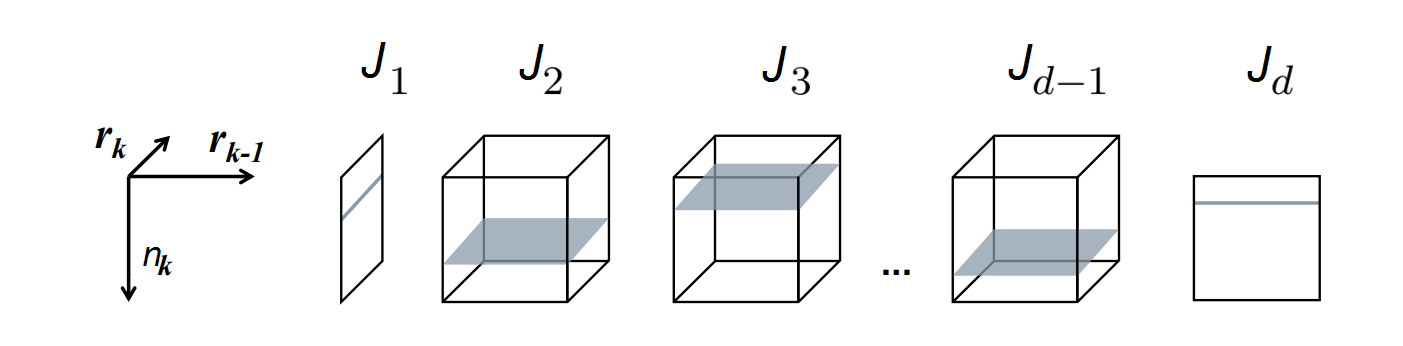

The storage of the TT-cores, $J_1, J_2, . . . , J_d$, requires at most $d · max_{1≤k≤d} N_k · (max_{0≤k≤d} R_k)^2$ memory cells, and hence the TT-approximation is free from the curse of dimensionality if the TT-ranks are bounded. The basic linear algebra operations (such as finding a norm, differentiation,
integration, and others) can also be implemented in the TT-format with polynomial complexity in dimensionality and mode size.

There are several efficient schemes to find TT-approximation if all or some of the elements of the initial tensor are known or may be generated by the function’s call. For example TT-SVD, TT-ALS and TT-CAM (Cross Approximation Method in the TT-format).

The last one was chosen by authors of TTOpt because the Cross Approximation Method for matrices is a well-established algorithm for building a rank-R approximation $\hat{J}$ of an implicitly given matrix $J$:

$J \approx \hat{J}$,   $\hat{J} = J_C \hat{J}^{−1}J_R$,

where $J_C$ consists of R columns of $J$, $J_R$ is composed of R rows of $J$, and $\hat{J}$ is a submatrix at their intersection. Such approximation (also called cross or skeleton decomposition) may be built iteratively using a well known alternating directions method and a maximum volume (maxvol) algorithm.

Of course the main interest in optimization problems is not the approximation itself, but the following property of the resulting maximum volume submatrix J. By using only a tiny fraction of function evaluations the optimizer builds a representation of J in the TT-format and finds a set of the largest elements.

It goes through all the TT-cores from 1 to d, this movement is called sweep.

Process is shown on the picture

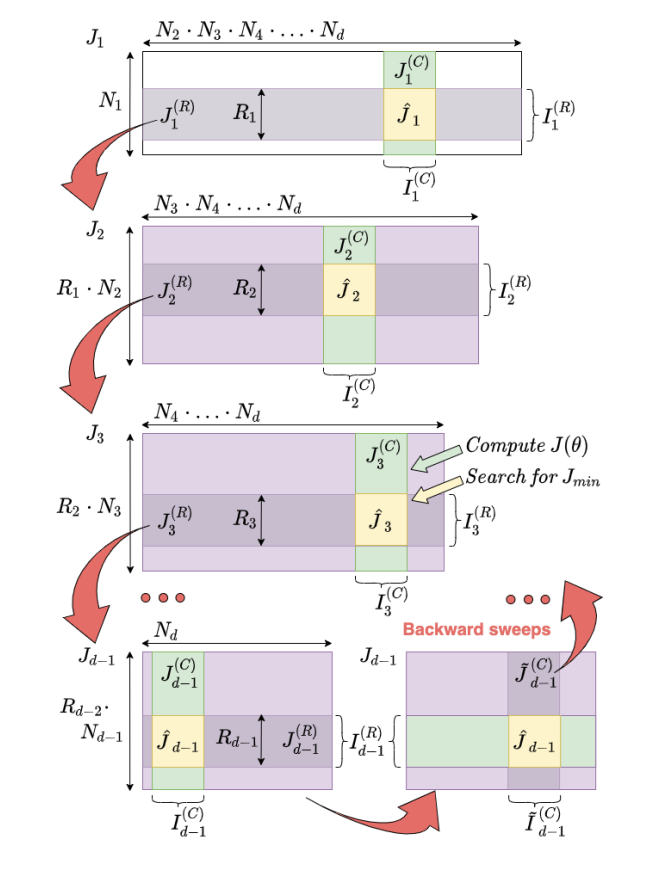

Conceptual scheme of one sweep based on the alternating direction and maximal-volume approaches for tensors is shown on the picture . Only a small part of the tensor is explicitly generated during this procedure, as shown here with green columns. For the simplicity of presentation, the rows and columns selected at iterations are drawn as continuous blocks (they are not in practice).

After the algorithm reaches the $J_d$ TT-core, optimizer repeats the process in the opposite direction, sampling the indices in a transposed way. These sequences of forward and backward sweeps are continued until the algorithm converges to some row and column indices for all unfolding matrices or until the user-specified limit on the number of requests to the objective function $J$ is exceeded.


TTOpt is available in this repository:  https://github.com/AndreiChertkov/ttopt.git

In [ ]:
!git clone --recursive https://github.com/AndreiChertkov/ttopt.git

Cloning into 'ttopt'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 212 (delta 111), reused 198 (delta 97), pack-reused 0
Receiving objects: 100% (212/212), 628.67 KiB | 6.16 MiB/s, done.
Resolving deltas: 100% (111/111), done.


##### BOHB


The other optimizer is Bayesian Optimization on Hyperband (BOHB). As it’s clear from its name this optimizer combines two ideas: Bayesian Optimization and Hyperband.


Bayesian optimization (BO) techniques model the conditional probability $p(y|λ)$ of a configuration’s performance on an evaluation metric $y$ (i.e., test accuracy), given a set of hyperparameters $λ$.

The idea of BO work is shown on the heatmap. It shows the validation error over a two-dimensional search space with red corresponding to areas with lower validation error. Configuration selection methods adaptively choose new configurations to train, proceeding in a sequential manner as indicated by the numbers.

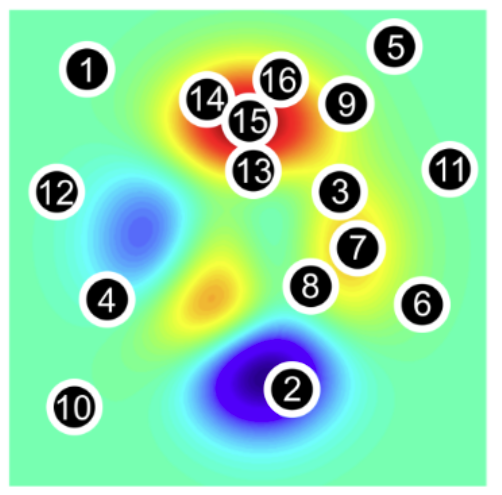


There are different methods to get probability of performance on the metric. The one is used in this notebook is described in details below.

Hyperband is a bandit strategy that dynamically allocates resources to a set of random configurations and uses Successive Halving to stop poorly performing configurations.

Successive Halving is a simple heuristic to allocate more resources to promising candidates. It is initialized with a set of configurations, a minimum and maximum budget, and a scaling parameter $η$. In the first stage all configurations are evaluated on the smallest budget (3 epoches on the plot). The losses are then sorted and only the best $\frac{1}{η}$ configurations are kept. For the following stage, the budget is increased. This is repeated until the maximum budget for a single configuration is reached. Within Hyperband, the budgets are chosen such that all Successive Halving executions require a similar total budget.

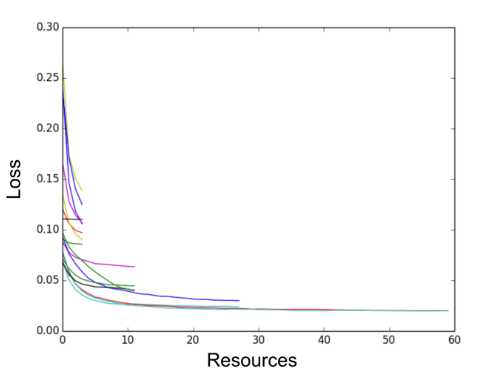


Hyperband approach is adaptive in computation, allocating more resources to promising hyperparameter configurations while quickly eliminating poor ones. By adaptively allocating resources, these approaches aim to examine orders-of-magnitude more hyperparameter configurations than approaches that uniformly train all configurations to completion, thereby quickly identifying good hyperparameters.

However, it only samples configurations randomly and does not learn
from previously sampled configurations. This can lead to a worse final performance than model-based approaches.


Hyperband has strong anytime performance, but for larger budgets does not perform much better than random search. In contrast, Bayesian optimization starts slowly (like random search), but given enough time outperforms Hyperband. BOHB achieves the best of both worlds, starting fast and also converging to the global optimum quickly.

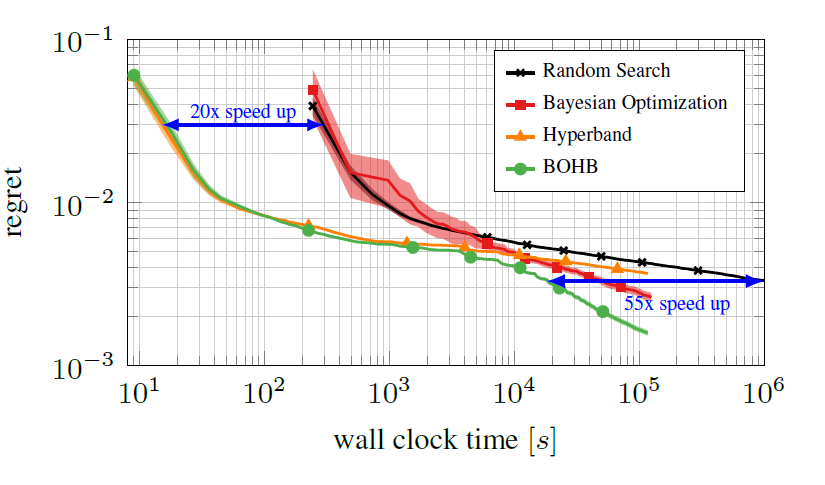

The repository https://github.com/automl/HpBandSter is convenient to use BOHB with network trainig. It would be necessary to pass to the optimazer range of hyperparameter if it is continuous or list of options if it is discrete choice.

Recommendation: Try not to use high dimensional spaces. The more dimensions BOHB has to optimize, the more it turns into random search.


However, this implementation of the optimizer is not appropriate for this task: here we need a special structure to explain to the optimizer range of possible architectures called search space.

##### Search Space

The predominant way of representing NAS search spaces is the directed acyclic graph (DAG). Most of the search spaces are hierarchical: macrograph contains subgraphs at its nodes or edges.

At each edge sits an EdgeData object. This is used to store informations at the edge, e.g. the operation (op) called primitive which is used when passing data from node to node. Some edges contain not one operation, but a whole list (it's called edge is not discretized). And choosing between these operations is the optimizer's job to find the architecture with the best performance.





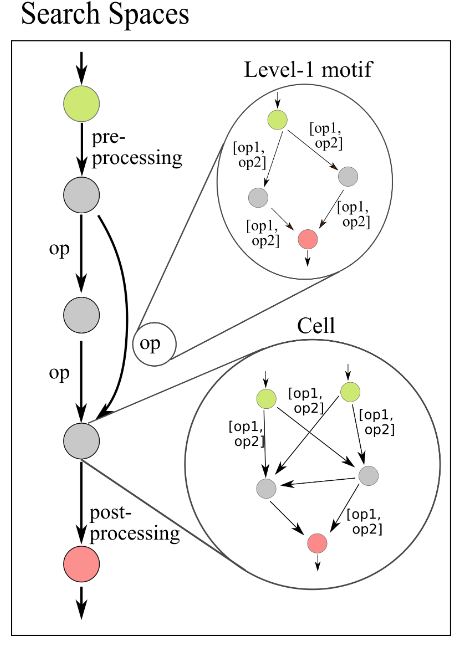

In NASLib cannot be used just native torch.nn.Module as operations. This is because of several reasons:

*   We need to make sure, that we find any subgraphs nested in an op, as it is the case for the hierarchical search space.
*   We might need to change some attributes of the op which were stored there earlier (this is the case here)
*   We might need a dedicated name for each op in care we want to make use of tabular benchmarks and query the performance of an architecture.

Search spaces are inherited in basic classes from both PyTorch and NetworkX. The latter is a well-maintained and tested Python package for graph creation and manipulation, where node and edge attributes can be arbitrary Python objects. This framework allows to represent multiple layers of graphs on top of the computational graph, allowing to treat nodes and edges both as primitive operations (e.g. convolution), but also nested graph-structures such as a DARTS cell, to create e.g. macro architectures of stacked cells. NetworkX allows to easily construct the search space via add_node, remove_node, add_edge, remove_edge, or traverse the topologically sorted graph in the forward pass of the PyTorch module using networkx.algorithms.dag.topological_sort.

There are two generations of search spaces:

1. tabular benchmarks, i.e. a benchmark where one can simply query (already has been trained) the performance and other metrics of a specific architecture in the search space given that as an input
  *   NasBench101SearchSpace
  *   NasBench201SearchSpace
  *   DartsSearchSpace (NasBench301SearchSpace)
  *   NasBenchNLPSearchSpace  
2. surrogate benchmarks, i.e. a model created on the existing tabular benchmark
  *   NasBench111SearchSpace
  *   NasBench211SearchSpace
  *   NasBench311SearchSpace
  *   NasBenchNLP11SearchSpace  


Both search spaces and BOHB optimizer suitable for it can be found in this repository https://github.com/automl/nas-bench-x11.git

In [ ]:
!git clone --recursive https://github.com/automl/nas-bench-x11.git

Cloning into 'nas-bench-x11'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 418 (delta 185), reused 341 (delta 120), pack-reused 0
Receiving objects: 100% (418/418), 428.50 KiB | 4.71 MiB/s, done.
Resolving deltas: 100% (185/185), done.



The Tree Parzen Estimator (TPE) is used as a Bayesian optimization realisation in this repository.

TPE method that uses a kernel density estimator to model the
densities

$l(x) = p(y < α|x, D)$

$g(x) = p(y > α|x, D)$

over the input configuration space instead of modeling the objective function f directly by $p(f|D)$. To select a new candidate $x_{new}$ to evaluate, it maximizes the ratio $\frac{l(x)}{g(x)}$. Due to the nature of kernel density estimators, TPE easily supports mixed continuous and discrete spaces, and model construction scales linearly in the number of data points.

To build $p(f|D)$ used statsmodels.nonparametric.kernel_density.KDEMultivariate.

Also we need some technical details from here: https://github.com/google-research/nasbench.git

In [ ]:
!git clone --recursive https://github.com/google-research/nasbench.git

Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 96 (delta 37), reused 88 (delta 35), pack-reused 0
Receiving objects: 100% (96/96), 345.23 KiB | 4.37 MiB/s, done.
Resolving deltas: 100% (37/37), done.


and models to predict benchmarks I've already loaded to my Google Drive
https://drive.google.com/drive/folders/1rVZRtpv2Bvnjkleol0r1l7i76-olnygm  

In [ ]:
import os
from google.colab import drive
drivefolder = "/content/gdrive/"
drive.mount(drivefolder)
drivefolder = os.path.join(drivefolder,"MyDrive/MachineLearning/NAS/")

Mounted at /content/gdrive/


### Code


##### Libraries

In [ ]:
!pip install autograd>=1.3
!pip install click
!pip install Cython
!pip install ConfigSpace==0.4.21
!pip install ipython
!pip install lightgbm==2.3.1
!pip install matplotlib
!pip install numpy==1.22.4
!pip install pandas
!pip install pathvalidate
!pip install psutil
!pip install scikit-image
!pip install scikit-learn>=0.23.1
!pip install scipy==1.10.1
!pip install statsmodels
!pip install torch>=1.9.0
!pip install torchvision>=0.10.0
!pip install tqdm
!pip install fvcore==0.1.5.post20210630
!pip install nasbench_pytorch==1.3.1

!pip install cma==3.3.0
!pip install nevergrad==0.8.0
!pip install pyproj==3.6.0
!pip install teneva==0.14.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.12.2 requires numpy>=1.23.0, but you have numpy 1.22.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210630-py3-none-any.whl size=60579 sha256=2508846ad62862c207c35c80354caf304ba3d4e2af0b852e244e3a56b99de65f
  Stored in directory: /root/.cache/pip/wheels/10/ad/bb/5a61a60b24e693b5f83a533a35853f38092c2a75ebcb3721c0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=30e2d63f9ead61495353c03c15d35df93349f4823aa175cf60c7690ebd3573a6
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.4/446.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Unfortunately, in nasbench is used version of tensorflow no longer supported by Google Colab.

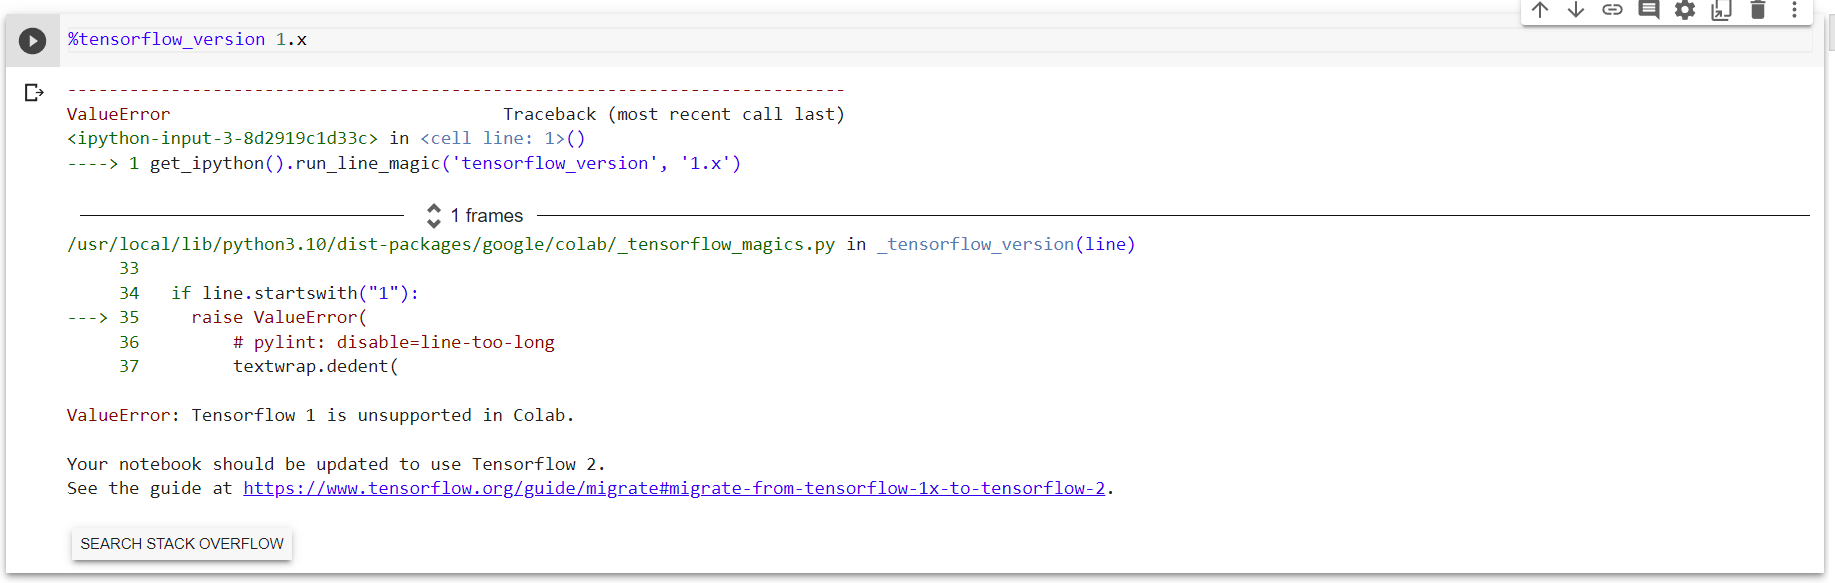

In [ ]:
#  (2.13.0.dev20230428, 2.13.0.dev20230429, 2.13.0.dev20230430, 2.13.0.dev20230501, 2.14.0.dev20230502, 2.14.0.dev20230503, 2.14.0.dev20230504, 2.14.0.dev20230505, 2.14.0.dev20230506, 2.14.0.dev20230507, 2.14.0.dev20230508, 2.14.0.dev20230509, 2.14.0.dev20230510, 2.14.0.dev20230511, 2.14.0.dev20230512, 2.14.0.dev20230513, 2.14.0.dev20230514, 2.14.0.dev20230515, 2.14.0.dev20230516, 2.14.0.dev20230517, 2.14.0.dev20230518, 2.14.0.dev20230519, 2.14.0.dev20230520, 2.14.0.dev20230523, 2.14.0.dev20230524, 2.14.0.dev20230525, 2.14.0.dev20230526, 2.14.0.dev20230527, 2.14.0.dev20230528, 2.14.0.dev20230529, 2.14.0.dev20230530, 2.14.0.dev20230531, 2.14.0.dev20230601, 2.14.0.dev20230602, 2.14.0.dev20230603, 2.14.0.dev20230604, 2.14.0.dev20230605, 2.14.0.dev20230606, 2.14.0.dev20230607, 2.14.0.dev20230608, 2.14.0.dev20230609, 2.14.0.dev20230610, 2.14.0.dev20230611, 2.14.0.dev20230612, 2.14.0.dev20230613, 2.14.0.dev20230614, 2.14.0.dev20230615, 2.14.0.dev20230616, 2.14.0.dev20230617, 2.14.0.dev20230618, 2.14.0.dev20230619, 2.14.0.dev20230620, 2.14.0.dev20230621, 2.14.0.dev20230622, 2.14.0.dev20230623, 2.14.0.dev20230624, 2.14.0.dev20230626, 2.14.0.dev20230627, 2.14.0.dev20230628, 2.14.0.dev20230629, 2.14.0.dev20230630, 2.14.0.dev20230701, 2.14.0.dev20230702, 2.14.0.dev20230703, 2.14.0.dev20230704, 2.14.0.dev20230705, 2.14.0.dev20230706, 2.14.0.dev20230707, 2.14.0.dev20230708, 2.14.0.dev20230709, 2.14.0.dev20230710, 2.14.0.dev20230711, 2.14.0.dev20230712, 2.14.0.dev20230713, 2.14.0.dev20230714, 2.14.0.dev20230715, 2.14.0.dev20230716, 2.14.0.dev20230717, 2.14.0.dev20230718, 2.14.0.dev20230720, 2.14.0.dev20230721, 2.14.0.dev20230722, 2.14.0.dev20230723, 2.14.0.dev20230724)

!pip install tf-nightly==2.14.0.dev20230502
# !tf_upgrade_v2 --infile nasbench/nasbench/lib/training_time.py --outfile nasbench/nasbench/lib/training_time.py
# class _TimingRunHook(tf.train.SessionRunHook): => class _TimingRunHook(tf.estimator.SessionRunHook):
!tf_upgrade_v2 --intree nasbench/ --outtree nasbench/

import os
# os.remove('/content/report.txt')

ERROR: Could not find a version that satisfies the requirement tf-nightly==2.14.0.dev20230502 (from versions: 2.14.0.dev20230516, 2.14.0.dev20230517, 2.14.0.dev20230518, 2.14.0.dev20230519, 2.14.0.dev20230520, 2.14.0.dev20230523, 2.14.0.dev20230524, 2.14.0.dev20230525, 2.14.0.dev20230526, 2.14.0.dev20230527, 2.14.0.dev20230528, 2.14.0.dev20230529, 2.14.0.dev20230530, 2.14.0.dev20230531, 2.14.0.dev20230601, 2.14.0.dev20230602, 2.14.0.dev20230603, 2.14.0.dev20230604, 2.14.0.dev20230605, 2.14.0.dev20230606, 2.14.0.dev20230607, 2.14.0.dev20230608, 2.14.0.dev20230609, 2.14.0.dev20230610, 2.14.0.dev20230611, 2.14.0.dev20230612, 2.14.0.dev20230613, 2.14.0.dev20230614, 2.14.0.dev20230615, 2.14.0.dev20230616, 2.14.0.dev20230617, 2.14.0.dev20230618, 2.14.0.dev20230619, 2.14.0.dev20230620, 2.14.0.dev20230621, 2.14.0.dev20230622, 2.14.0.dev20230623, 2.14.0.dev20230624, 2.14.0.dev20230626, 2.14.0.dev20230627, 2.14.0.dev20230628, 2.14.0.dev20230629, 2.14.0.dev20230630, 2.14.0.dev20230701, 2.14.0.dev

In [ ]:
import sys
sys.path.append('/content/ttopt')
sys.path.append('/content/nasbench')
sys.path.append('/content/nas-bench-x11')

In [ ]:
import numpy as np
import pandas as pd
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import copy
import json
import collections
import warnings
from tqdm import tqdm_notebook as tqdm

import naslib.search_spaces as search_spaces
from naslib.search_spaces.core.graph import Graph, EdgeData
from naslib.search_spaces.core.query_metrics import Metric
from naslib.search_spaces.darts.conversions import convert_naslib_to_genotype, set_vector_to_mutable, convert_compact_to_naslib, convert_naslib_to_compact, convert_naslib_to_config
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str, convert_naslib_to_op_indices
from naslib.defaults.additional_primitives import DropPathWrapper

from naslib.optimizers import BOHB
import naslib.utils as utils
from naslib.utils.utils import get_train_val_loaders
from naslib.utils.get_dataset_api import get_darts_api, get_nasbench211_api
from nas_bench_x11.api import load_ensemble
from fvcore.common.config import CfgNode
import statsmodels.api as sm


##### Visualisation




Let's define some functions for visualisation.

In [ ]:
def calc_node_positions(nx_graph):
  pos = nx.kamada_kawai_layout(nx_graph)
  pos = {k:np.around(pos[k], decimals=2) for k in pos}
  node_ids = list(pos.keys())
  for i, k1 in enumerate(node_ids):
    for k2 in node_ids[k1:]:
        if np.array_equal(pos[k1], pos[k2]):
            pos[k1][1] += 0.1
            pos[k2][0] += 0.1
  return pos

def draw_graph(nx_graph, title="makrograph", node_colors=None):
    if title.find("_cell") != -1:
        pos = {1: np.array([0.48, 0.82]), 2: np.array([0.58, 0.72]), 3: np.array([-0.54,  0.5 ]), 4: np.array([-0.25, -0.08]), 5: np.array([ 0.13, -0.24]), 6: np.array([ 0.67, -0.31]), 7: np.array([-0.67, -1.  ])}
    elif isinstance(nx_graph, search_spaces.NasBench211SearchSpace):
        pos = {1: np.array([1. , 1. ]), 2: np.array([0.6, 1. ]), 3:  np.array([0.4, 1.]),  4: np.array([0.2, 1.]),   5: np.array([-0., 1.]),    6: np.array([-0.2, 1.]),  7: np.array([-0.4, 1. ]),
               8: np.array([0.6 , 0.]), 9: np.array([0.4 , 0.]), 10: np.array([0.2, 0.]), 11: np.array([0. , -0.]),  12: np.array([-0.2, -0.]), 13: np.array([-0.4, -0.]),
               14: np.array([0.3, -1]), 15: np.array([0.1, -1]), 16: np.array([-0.1,-1]),  17: np.array([-0.3, -1]), 18: np.array([-0.5, -1]),  19: np.array([-0.7, -1]), 20: np.array([-1, -1.  ])}
    else:
        pos = calc_node_positions(nx_graph)
    plt.show()
    if node_colors is None:
      node_colors={'reduction_cell': (1, 0.7, 0.7), 'normal_cell':(0.7, 0.7, 1), 'not a subgraph node':(0.7, 1, 0.7) }
    node_color_map = []
    drawn_cells = set()
    legend_labels = ['not a subgraph node']
    markers = [plt.Line2D([0,0],[0,0],color=node_colors[legend_labels[0]], linestyle=' ', marker='o',  markersize=12) ]
    for node_idx in nx.algorithms.dag.lexicographical_topological_sort(nx_graph):
          if "subgraph" in nx_graph.nodes[node_idx]:
              cell_type = nx_graph.nodes[node_idx]["subgraph"].name
              node_color_map.append(node_colors[cell_type])
              if cell_type not in drawn_cells:
                  drawn_cells.add(cell_type)
                  draw_graph(nx_graph.nodes[node_idx]["subgraph"], title = cell_type)
                  legend_labels.append(cell_type)
                  markers.append(plt.Line2D([0,0],[0,0],color=node_colors[cell_type], linestyle=' ', marker='o',  markersize=12))
          else:
            node_color_map.append(node_colors[legend_labels[0]])
    edge_colors ={
                  'cell': (1,0,0), 'Stem': (0,0,0.7), 'Sequential': (0,0.6,0.6), 'ReLUConvBN1x1': (0.6,0.8,0), 'FactorizedReduce': (0,0,0.9), 'ResNetBasicblock': (0.6,0.8,0),
                  'edge is not discretized': (0,0,0), 'Identity': (0,0,0.7),
                  'MaxPool': (0.3,0.6,0), 'AvgPool': (0.6,0.3,0), 'SepConv3x3': (0,0.8,0.6), 'SepConv5x5': (0,0.6,0.8), 'DilConv3x3': (0.8,0,0.6), 'DilConv5x5': (0.6,0,0.8),
                  'AvgPool1x1': (0.6,0.3,0), 'ReLUConvBN3x3': (0.8,0.6,0), 'Zero': (0,0.6,0.8)
                  }
    edge_color_map = []
    for i,j in nx_graph.edges:
          edge_data = nx_graph.get_edge_data(i,j)
          if isinstance(edge_data.op, Graph):
              edge_op_name = edge_data.op.name
              if edge_op_name not in legend_labels:
                  draw_graph(edge_data.op, title = edge_op_name)
          else:
              if not isinstance(edge_data['op'], list):
                  edge_op_name = edge_data['op'].get_op_name
              else:
                  edge_op_name = 'edge is not discretized'
          if edge_op_name not in legend_labels:
              legend_labels.append(edge_op_name)
              markers.append(plt.Line2D([0,0],[0,0],color=edge_colors[edge_op_name], linestyle='-'))
          edge_color_map.append(edge_colors[edge_op_name])
    nx.draw(nx_graph, pos, with_labels=True, node_color=node_color_map, edge_color=edge_color_map)
    plt.suptitle(title)
    plt.legend(markers, legend_labels, loc='lower right')
    plt.show()



In [ ]:
def distribute_over_the_grid(dict_to_change, max_time=None):
    result_dict = {}
    list_of_keys = list(dict_to_change.keys())
    if max_time is None:
        max_time = max([max(dict_to_change[key]["train_time"]) for key in list_of_keys])
    for key in list_of_keys:
        result_dict[key] = []
        start_acc = 0
        start_t = 0
        for acc, t in zip(dict_to_change[key]["accuracy"], dict_to_change[key]["train_time"]):
            while start_t <= t:
                result_dict[key].append(start_acc)
                start_t += 100
            start_acc = acc
        while start_t <= max_time:
            result_dict[key].append(start_acc)
            start_t += 100
    return [int(t*100) for t in range(len(result_dict[key]))], result_dict


def build_plot(data_to_plot, color_legend=None, title=None, file_to_save_results=".", max_time=None):
    list_of_plots = list(data_to_plot.keys())
    if isinstance(data_to_plot[list_of_plots[0]], dict):
        x, data_to_plot = distribute_over_the_grid(data_to_plot, max_time=max_time)
        plt.xlim((0, max(x)))
        plt.ylim((90, 100))
        opt_curv = True
    else:
        opt_curv = False
    if color_legend is None:
        color_legend = {m: cl for m, cl in zip(list_of_plots, ["g","b","r","m","c","y"])}
    legend_lables = []
    for key in color_legend:
        if opt_curv:
            plt.plot(x, data_to_plot[key], color=color_legend[key])
        else:
            plt.plot(data_to_plot[key], color=color_legend[key])
        legend_lables.append(f"{color_legend[key]} best_value = {max(data_to_plot[key])}")
    # matplotlib_cachedir = matplotlib.get_cachedir()
    # for f in os.listdir(matplotlib_cachedir):
    #   os.remove(os.path.join(matplotlib_cachedir,f))
    plt.suptitle(title)
    markers = [plt.Line2D([0,0],[0,0],color=color, linestyle='-') for color in color_legend.values()]
    plt.legend(markers, color_legend.keys(), loc='lower right')
    plt.savefig(file_to_save_results)
    plt.show()


#####  Search Spaces



The NasBench211SearchSpace (as its parent class the NasBench201SearchSpace) search space consists of a single normal cell which is replicated multiple times in a macro architecture interleaved by manually defined resnet-like reduction cells. The cell topology is fixed in the cell and consists of:

* 1 input, 2 intermediate and 1 output node;
* a summation operation on each of the intermediate and output nodes;
* 5 operation choices in each of 6 edges
  * 'none'
  * 'skip_connect'
  * 'nor_conv_1x1'
  * 'nor_conv_3x3'
  * 'avg_pool_3x3'

LightGBM regressor model was created for quering NAS-Bench-211 to further evaluate our surrogate creation technique (since NASBench-
201 already has complete learning curves). NASLib authors trained the surrogate on 90% of architectures from NAS-Bench-201 (14 062 architectures) and tested on the remaining 10%.

dataset_api: is a model to use for querying model performance. NASLIB does not implement saving it inside a search space object to make it possible to use the same API in all search spaces and save memory.

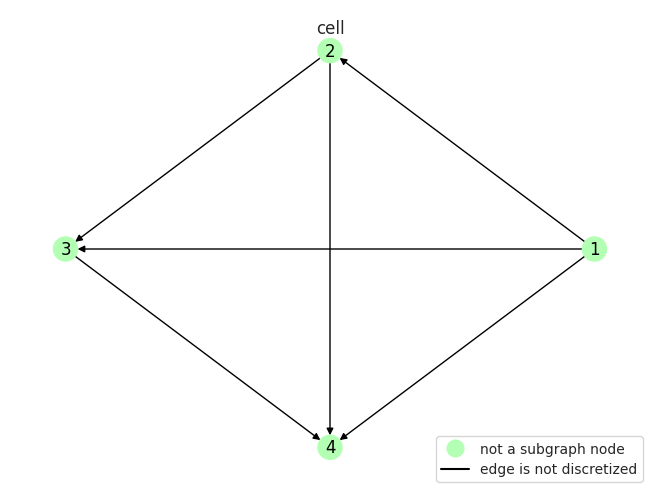

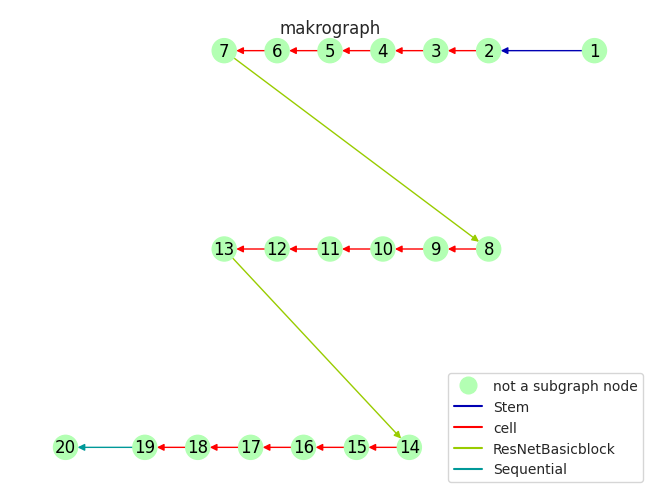

In [ ]:
def query(self, metric=None, dataset=None, path=None, epoch=-1, full_lc=False, dataset_api=None):
        arch_str = convert_naslib_to_str(self)
        nb211_prediction = dataset_api.predict(config=arch_str,
                                                representation="arch_str",
                                                search_space='nb201_c10',
                                                with_noise=False)
        len_of_nb211_prediction = len(nb211_prediction)
        if metric == Metric.TRAIN_TIME:
            if epoch == -1:
                    return len_of_nb211_prediction
            else:
                    return epoch if len_of_nb211_prediction > epoch else len_of_nb211_prediction
        if full_lc and epoch == -1:
            return nb211_prediction
        elif full_lc and epoch != -1:
            return nb211_prediction[:epoch]
        else:
            # return the value of the metric only at the specified epoch
            if epoch == -1:  epoch = len_of_nb211_prediction-1
            return nb211_prediction[:epoch].max()

search_spaces.NasBench211SearchSpace.query = query

def save_labeled_architecture(self, file_path):
        """
        It saves architecture as list of op_indices.
        """
        if self.op_indices is None:
            self.op_indices = convert_naslib_to_op_indices(self)
        # assert self.op_indices is not None,  'search_space is not discretized'
        with open(file_path, 'w') as f:
            f.write(', '.join(str(x) for x in self.op_indices ))

search_spaces.NasBench211SearchSpace.save_labeled_architecture = save_labeled_architecture

def load_labeled_architecture(self, file_path):
        """
        This is meant to be called by a new NasBench211SearchSpace() object
        (one that has not already been discretized).
        It updates the graph object to match the already saved architecture.
        """
        with open(file_path) as f:
              op_indices = (int(x) for x in f.read().split(","))
        self.set_op_indices(op_indices)

search_spaces.NasBench211SearchSpace.load_labeled_architecture = load_labeled_architecture

search_space = search_spaces.NasBench211SearchSpace()
draw_graph(search_space)


Now we can calculate number of possible architectures:
$5^6 = 15625$

In addition to the naslib object, there are search space two representation types: op_indices and str

op_indices - indexes of operations in the list in order of edges 1-2, 1-3, 1-4,
2-3, 2-4, 3-4. This representation is used to  to discretize the search space.


search_space op_indices [4, 0, 2, 1, 4, 4]
search_space str |avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_conv_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|


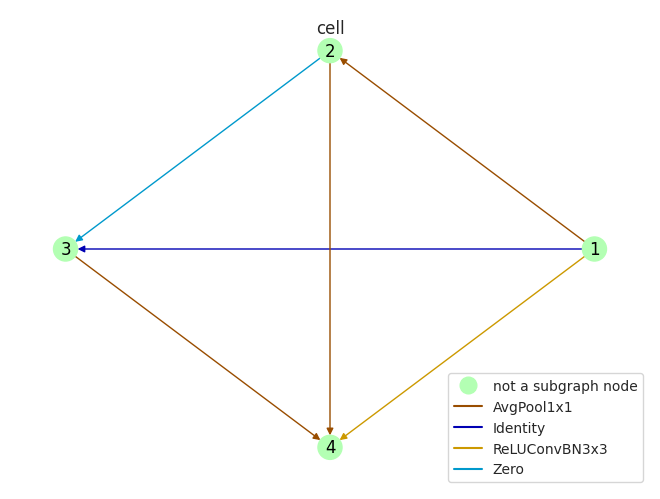

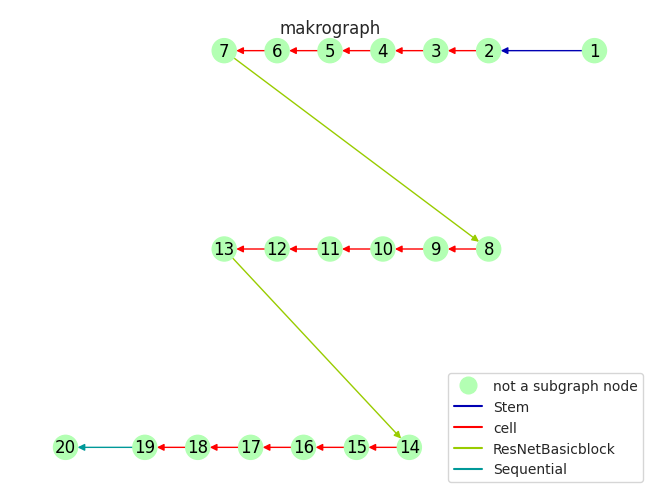

In [ ]:
search_space.sample_random_architecture()
op_indices = convert_naslib_to_op_indices(search_space)
print("search_space op_indices", op_indices)
op_indices = convert_naslib_to_str(search_space)
print("search_space str", op_indices)

draw_graph(search_space)

The NasBench311SearchSpace (as its parent class the DartsSearchSpace) has to types of subgraphs: the reduction cell and the normal cell. Before discretization both cells have similar topology


* 2 input, 4 intermediate and 1 output node;
* a summation operation on each of the intermediate nodes and cat for output one;
* edges to output node (37, 47, 57, 67) are always skip connections
* 7 operation choices in each of 14 undiscretized edges
 * 'max_pool_3x3',
 * 'avg_pool_3x3',
 * 'skip_connect',
 * 'sep_conv_3x3',
 * 'sep_conv_5x5',
 * 'dil_conv_3x3',
 * 'dil_conv_5x5'

Discretization randomly leaves 8 of 14 edges (deletes 6 edges).    The remaining edges are discretized using one of 7 operations.

 LightGBM regressor model was created for quering NAS-Bench-311 by using the training data from NAS-Bench-301, which consists of 40 000 random architectures along with 26 000 additional architectures generated by evolution, Bayesian optimization, and one-shot techniques in order to achieve good coverage over the search space.

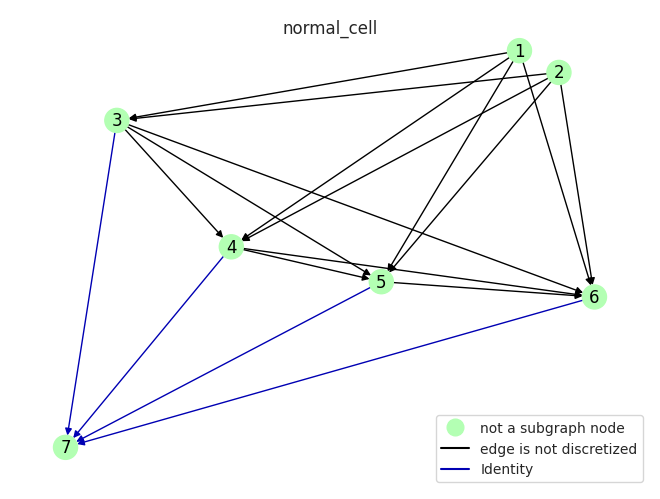

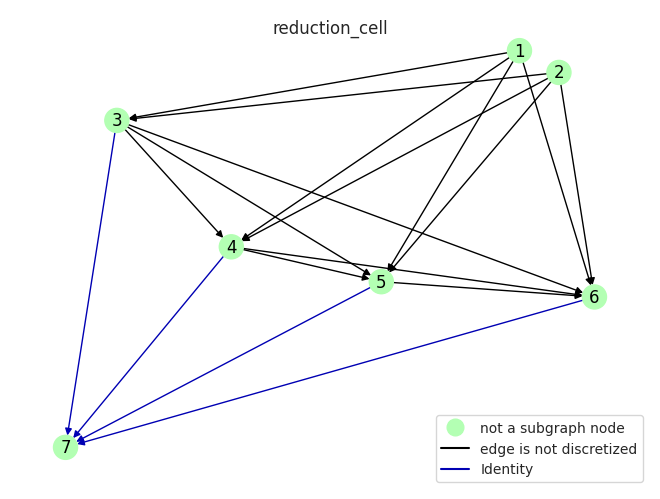

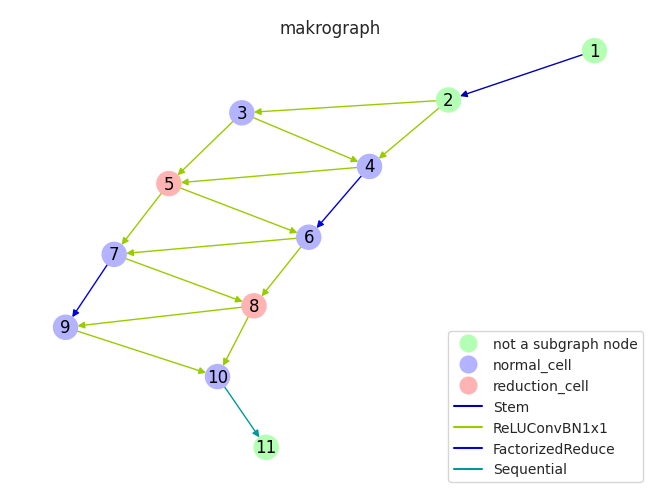

In [ ]:
class NasBench311SearchSpace(search_spaces.DartsSearchSpace):

    def __init__(self):
        super().__init__()
        self.space_name = 'nasbench311'

    def query(self, metric=None, dataset=None, path=None, epoch=-1, full_lc=False, dataset_api=None):
            """
            NasBench311SearchSpace.query() have the same input parametrs order
            as it is in DartsSearchSpace.query() (parent class method)
            """
            genotype = convert_naslib_to_genotype(self)
            try:
                nb311_prediction = dataset_api.predict(config=genotype, representation="genotype", with_noise=False)
            except:
              return  0
            len_of_nb311_prediction = len(nb311_prediction)
            if metric == Metric.TRAIN_TIME:
                if epoch == -1:
                    return len_of_nb311_prediction
                else:
                    return epoch if len_of_nb311_prediction > epoch else len_of_nb311_prediction
            if full_lc and epoch == -1:
                return nb311_prediction
            elif full_lc and epoch != -1:
                return nb311_prediction[:epoch]
            else:
                # return the value of the metric only at the specified epoch
                if epoch == -1:  epoch = len_of_nb311_prediction-1
                return nb311_prediction[:epoch].max()

    def set_compact(self, compact):
        # This will update the edges in the naslib object to match compact
        self.compact = compact
        convert_compact_to_naslib(compact, self)
        self.is_discretized = True

    @staticmethod
    def sample_vector(datum, bws, vartypes, compact, vector, cell_type=None):
        """
        This will sample a new vector given the kde model.
        """
        cell = 0 if cell_type == 'normal' else 1
        ind = 0
        for m, bw, t in zip(datum, bws, vartypes):
            if ind % 2 == 0:
                pair = ind // 2
                inputs = pair // 2 + 2
                choice = np.random.choice(inputs)
                if pair % 2 == 0:
                    while compact[cell][pair+1][0] == choice:
                        choice = np.random.choice(inputs)
                    compact[cell][pair][0] = choice
                    vector.append(choice)
                elif pair % 2 != 0:
                    while compact[cell][pair-1][0] == choice:
                        choice = np.random.choice(inputs)
                    compact[cell][pair][0] = choice
                    vector.append(choice)
                # vector.append(int(m))
            else:
                if np.random.rand() < (1 - bw):
                    vector.append(int(m))
                else:
                    vector.append(np.random.randint(t))
            ind += 1
        return vector

    def sample_random_architecture(self, dataset_api=None):
        """
        This will sample a random architecture and update the edges in the
        naslib object accordingly.
        """
        compact = [[], []]
        for i in range(4):
            ops = np.random.choice(range(7), 4)
            nodes_in_normal = np.random.choice(range(i+2), 2, replace=False)
            nodes_in_reduce = np.random.choice(range(i+2), 2, replace=False)
            compact[0].extend([(nodes_in_normal[0], ops[0]), (nodes_in_normal[1], ops[1])])
            compact[1].extend([(nodes_in_reduce[0], ops[2]), (nodes_in_reduce[1], ops[3])])
        self.set_compact(compact)

    def save_labeled_architecture(self, file_path):
        """
        It saves architecture as compact.
        """
        assert self.compact is not None,  'search_space is not discretized'
        with open(file_path, 'w') as f:
            f.write('\n'.join('{}, {}'.format(x[0],x[1]) for cell in self.compact  for x in cell))

    def load_labeled_architecture(self, file_path):
        """
        This is meant to be called by a new DartsSearchSpace() object
        (one that has not already been discretized).
        It updates the graph object to match the already saved architecture.
        """
        with open(file_path) as f:
              compact_list = [tuple(map(int, i.split(','))) for i in f]
        compact = (tuple(compact_list[:8]), tuple(compact_list[8:]))
        self.load_labeled = True
        self.set_compact(compact)


search_space = NasBench311SearchSpace()
draw_graph(search_space)

Now we can calculate number of possible architectures:

$\frac{14!}{8!(14-8)!}*2*7^{16} = 1.99596981001023606*10^{17}$



In addition to the naslib object, there are search space three representation types: compact, genotype and config.

compact consist of two components first one for normal cell and second one for reduction cell. Each cell-component consist of 8 tuples. First element of each tuple is an index of the node that starts the edge. The second element is an index of operation. An older of edges is the same with random exclusion 6 of the edges: 1-3, 2-3, 1-4, 2-4, 3-4, 1-5, 2-5, 3-5, 4-5, 1-6, 2-6, 3-6, 4-6, 5-6. This representation is used to discretize the search space, but absence of the end-edge node in the tuples may cause a confusion in architectures.

compact (((0, 4), (1, 2), (1, 4), (2, 1), (1, 0), (2, 5), (2, 3), (3, 3)), ((0, 2), (1, 0), (1, 3), (2, 5), (1, 5), (3, 4), (1, 0), (3, 6)))
genotype Genotype(normal=[('sep_conv_5x5', 0), ('skip_connect', 1), ('sep_conv_5x5', 1), ('avg_pool_3x3', 2), ('max_pool_3x3', 1), ('dil_conv_3x3', 2), ('sep_conv_3x3', 2), ('sep_conv_3x3', 3)], normal_concat=[2, 3, 4, 5, 6], reduce=[('skip_connect', 0), ('max_pool_3x3', 1), ('sep_conv_3x3', 1), ('dil_conv_3x3', 2), ('dil_conv_3x3', 1), ('sep_conv_5x5', 3), ('max_pool_3x3', 1), ('dil_conv_5x5', 3)], reduce_concat=[4, 5, 6])
config {'NetworkSelectorDatasetInfo:darts:edge_normal_0': 'sep_conv_5x5', 'NetworkSelectorDatasetInfo:darts:edge_normal_1': 'skip_connect', 'NetworkSelectorDatasetInfo:darts:edge_normal_3': 'sep_conv_5x5', 'NetworkSelectorDatasetInfo:darts:edge_normal_4': 'avg_pool_3x3', 'NetworkSelectorDatasetInfo:darts:inputs_node_normal_3': '1_2', 'NetworkSelectorDatasetInfo:darts:edge_normal_6': 'max_pool_3x3', 'NetworkSelectorDatasetInfo:d

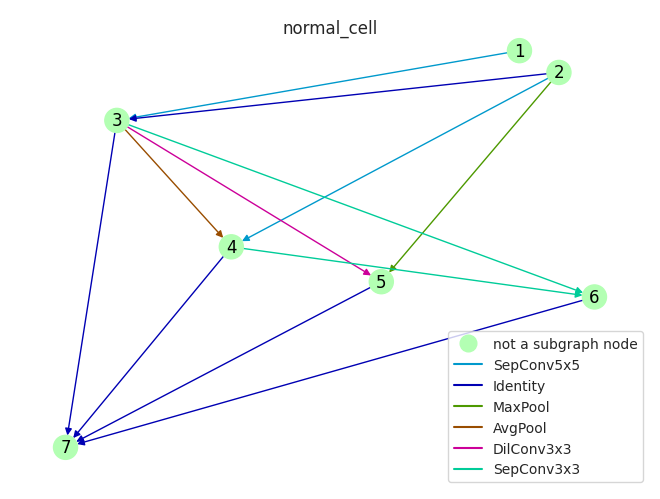

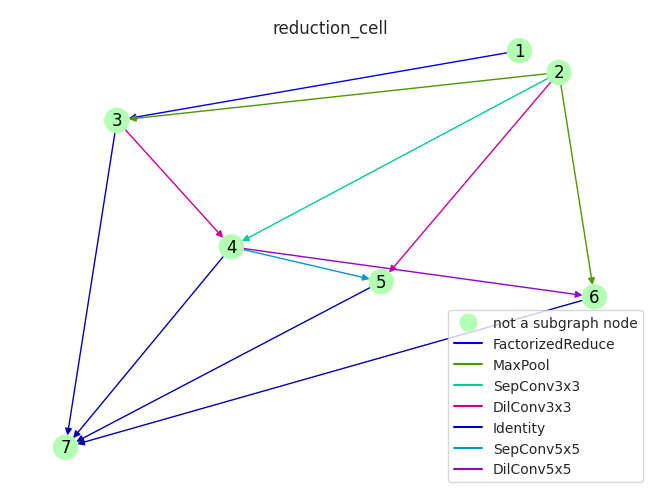

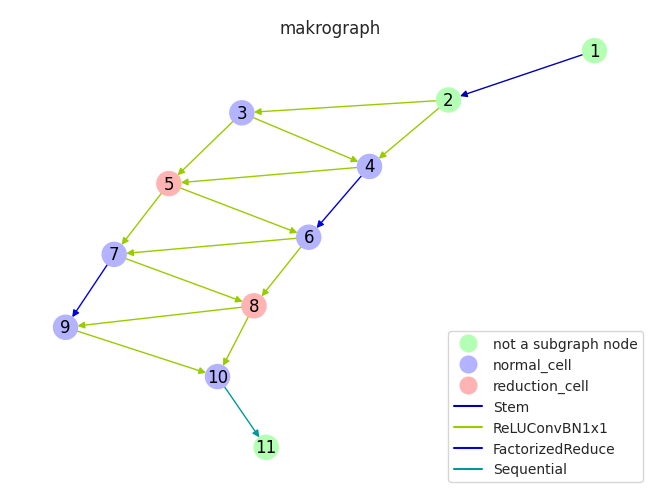

In [ ]:
search_space.sample_random_architecture()
compact = convert_naslib_to_compact(search_space)
print("compact", compact)
genotype = convert_naslib_to_genotype(search_space)
print("genotype", genotype)
config = convert_naslib_to_config(search_space)
print("config", config)

draw_graph(search_space)

In [ ]:
def load_config(search_space_name=""):
    """
    load recommended search and train parameters
    """
    with open(os.path.join(os.getcwd(),'nas-bench-x11', 'naslib', 'defaults', 'darts_defaults.yaml')) as f:
        config = CfgNode.load_cfg(f)
    if search_space_name == "nasbench311":
        config.model_path = os.path.join(drivefolder, 'checkpoints/nb311-v0.5')
    elif search_space_name == "nasbench211":
        config.search_space = search_space_name
        config.model_path=os.path.join(drivefolder, 'checkpoints/nb211-v0.5')
    config.data = './data'
    config.save = 'savedir'
    if not os.path.isdir(config.save):
        os.mkdir(config.save)
        os.mkdir(config.save + "/search")
        os.mkdir(config.save + "/eval")
    if hasattr(config, 'evaluation') and hasattr(config.evaluation, 'epochs'):
        config.evaluation.pop("epochs")
    config.surrogate_search_space = search_space_name
    if not hasattr(config.search, 'fidelity'):
          config.search.fidelity = 200
    return  config

#####  Benchmark prediction check

Let’s evaluate prediction of the query model with randomly selected architecture.

In [ ]:
def evaluate(search_space, dataset_api, config):
      """
      Args:
        search_space: Parsed model you want to directly evaluate and ignore the final model
              from the optimizer.
        dataset_api: Dataset API to use for querying model performance.
        config:
      """
      result_dict = {"benchmark prediction": list(search_space.query( metric=Metric.TRAIN_ACCURACY, dataset=config.dataset, full_lc=True, dataset_api=dataset_api)) ,
                      "train":[], "valid":[]}

      if not search_space.is_parsed:
              search_space.parse()
      device = torch.device("cuda:0")
      search_space.cuda(device)
      search_space.reset_weights(inplace=True)
      search_space.train()
      # Enable drop path
      search_space.update_edges(
          update_func=lambda edge: edge.data.set('op', DropPathWrapper(edge.data.op)),
          scope=search_space.OPTIMIZER_SCOPE,
          private_edge_data=True
      )
      train_queue, _, valid_queue, _, _ = get_train_val_loaders(config, mode='val')
      start_epoch = 0
      epochs = len(result_dict["benchmark prediction"])
      if hasattr(config, 'evaluation') and hasattr(config.evaluation, 'grad_clip'):
          grad_clip = config.evaluation.grad_clip
      else:
          grad_clip = 0
      loss = torch.nn.CrossEntropyLoss()
      optim = torch.optim.SGD(search_space.parameters(), lr=config.evaluation.learning_rate,
              momentum=config.evaluation.momentum, weight_decay=config.evaluation.weight_decay,)

      for e in tqdm(range(start_epoch, epochs), desc='training '):
              # update drop path probability
              drop_path_prob = config.evaluation.drop_path_prob * e / epochs
              search_space.update_edges(
                  update_func=lambda edge: edge.data.set('drop_path_prob', drop_path_prob),
                  scope=search_space.OPTIMIZER_SCOPE,
                  private_edge_data=True
              )

              # Train queue
              correct = 0
              for i, (input_train, target_train) in enumerate(train_queue):
                  input_train = input_train.to(device)
                  target_train = target_train.to(device, non_blocking=True)

                  optim.zero_grad()
                  logits_train = search_space(input_train)
                  train_loss = loss(logits_train, target_train)
                  train_loss.backward()
                  if grad_clip:
                      torch.nn.utils.clip_grad_norm_(search_space.parameters(), grad_clip)
                  optim.step()
                  logits_train = torch.argmax(logits_train, dim=1)
                  correct += (logits_train == target_train).float().sum()
              train_accuracy = 100 * correct / len(train_queue.dataset)
              result_dict["train"].append(train_accuracy.item())

              # Validation queue
              correct = 0
              for i, (input_valid, target_valid) in enumerate(valid_queue):
                  input_valid = input_valid.cuda().float()
                  target_valid = target_valid.cuda().float()
                  # just log the validation accuracy
                  with torch.no_grad():
                      logits_valid = search_space(input_valid)
                      logits_valid = torch.argmax(logits_valid, dim=1)
                      correct += (logits_valid == target_valid).float().sum()
              valid_accuracy = 100 * correct / len(valid_queue.dataset)
              result_dict["valid"].append(valid_accuracy.item())

      build_plot(result_dict, file_to_save_results="search_space_evaluation.png")
      return result_dict

Real learning curve with recommend hyperparameters has completely wrong shape.

It looked like one or several hyperparameters should slowdown training. But didn't find combination of hyperparameters that approximate benchmark prediction better than recommend ones.

I assume that such a difference between the benchmark prediction and the real learning curve is due to the insufficient number of architectures for training (66,000 versus $10^{17}$ possible architectures).

/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb311-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


100%|██████████| 170498071/170498071 [00:06<00:00, 26618601.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-18-d07ffea1faa0>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(start_epoch, epochs), desc='training '):


training :   0%|          | 0/98 [00:00<?, ?it/s]

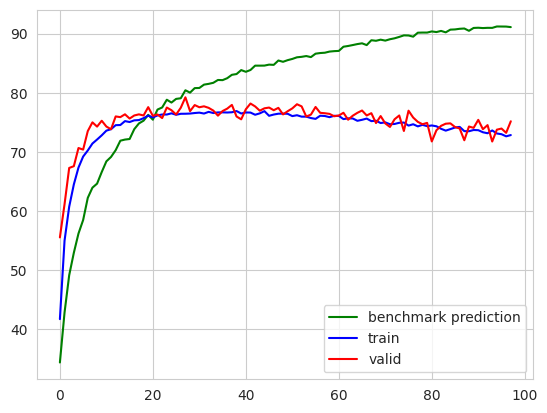

{'benchmark prediction': [34.41347193436489,
  42.852853018234555,
  49.16590581590193,
  52.960845855087754,
  56.216116615871925,
  58.493705122595316,
  62.24354461082062,
  63.966880474703295,
  64.6489241256223,
  66.60613467702383,
  68.41455863682509,
  69.16174932941117,
  70.3057499543601,
  71.90535605306742,
  72.09827478913253,
  72.19242040026015,
  73.8585343726616,
  74.82302999712684,
  75.29410910616633,
  76.28072152943578,
  75.45742426390055,
  77.17006401402395,
  77.52419068168699,
  78.83248509207522,
  78.35599958014232,
  78.97203229215513,
  79.08098687726289,
  80.43229369571513,
  80.03266092595682,
  80.79489101932238,
  80.82247049278284,
  81.38419178655991,
  81.51466023798017,
  81.69429322942047,
  82.17167755422051,
  82.14595149231401,
  82.47415660708815,
  83.04564617175012,
  83.1731607566922,
  83.84307476070394,
  83.55671553117367,
  83.85888324038355,
  84.59540518379578,
  84.59454641118201,
  84.60372739781164,
  84.76738194305834,
  84.7280

In [ ]:
search_space = NasBench311SearchSpace()
search_space.sample_random_architecture()

config = load_config(search_space.space_name)
dataset_api = load_ensemble(config.model_path)
evaluate(search_space, dataset_api, config);

#####  Replicate Search Space with torch.nn.Module

Unfortunately, I wasn't able to get the required 4 hours of GPU to train NasBench211SearchSpace. This shows the need of saving intermediate training results to be able continue training from the epoch where it was interrupted.

Also do not forget that the ultimate goal of NAS optimization is to get a NN model that can then be deployed.

It's cannot be done with just torch.save() because of second parent class networkx.DiGraph.

So let's create a class for each search space that objects can replicate search space architecture (with weights) and be saved by torch.save() function.


In [ ]:
class Cell2xxModel(torch.nn.Module):
    def __init__(self, search_space): #, is_makrograph=False, **kwargs):
        super(Cell2xxModel, self).__init__()
        for i,j in search_space.edges:
          edge_data = search_space.get_edge_data(i,j)
          assert isinstance(edge_data['op'], search_spaces.core.primitives.AbstractPrimitive),  'search_space is not discretized'
          edge_op_name = edge_data['op'].get_op_name
          module_name = f"celledge_{i}_{j}"
          self.add_module(module_name, edge_data.op)

    def forward(self, x):
        x2 = self.celledge_1_2(x)
        x3 = self.celledge_1_3(x) + self.celledge_2_3(x2)
        x4 = self.celledge_1_4(x) + self.celledge_2_4(x2) + self.celledge_3_4(x3)
        return x4

class NB2xx_Model(torch.nn.Module):
    def __init__(self, search_space):
        super(NB2xx_Model, self).__init__()
        for i,j in search_space.edges:
          edge_data = search_space.get_edge_data(i,j)
          # inject edge data only for AbstractPrimitive, not Graphs
          if isinstance(edge_data.op, Graph):
              module_name = f"edge_{i}_{j}_{edge_data.op.name}"
              self.add_module(module_name, Cell2xxModel(edge_data.op))
          else:
              edge_data = search_space.get_edge_data(i,j)
              if not isinstance(edge_data['op'], list):
                  edge_op_name = edge_data['op'].get_op_name
                  module_name = f"edge_{i}_{j}_{edge_op_name}"
                  self.add_module(module_name, edge_data.op)


    def forward(self, x):
        x = self.edge_1_2_Stem(x)
        x = self.edge_2_3_cell(x)
        x = self.edge_3_4_cell(x)
        x = self.edge_4_5_cell(x)
        x = self.edge_5_6_cell(x)
        x = self.edge_6_7_cell(x)
        x = self.edge_7_8_ResNetBasicblock(x)
        x = self.edge_8_9_cell(x)
        x = self.edge_9_10_cell(x)
        x = self.edge_10_11_cell(x)
        x = self.edge_11_12_cell(x)
        x = self.edge_12_13_cell(x)
        x = self.edge_13_14_ResNetBasicblock(x)
        x = self.edge_14_15_cell(x)
        x = self.edge_15_16_cell(x)
        x = self.edge_16_17_cell(x)
        x = self.edge_17_18_cell(x)
        x = self.edge_18_19_cell(x)
        x = self.edge_19_20_Sequential(x)
        return x


def get_NN_model(self):
  return NB2xx_Model(self)

search_spaces.NasBench211SearchSpace.get_NN_model = get_NN_model

In [ ]:
class CellModel(torch.nn.Module):
    def __init__(self, search_space, module_prefix=''): #, is_makrograph=False, **kwargs):
        super(CellModel, self).__init__()
        if module_prefix: module_prefix += "_"
        self.input_nodes_num = search_space.num_input_nodes()
        self.nodes_num = search_space.number_of_nodes()
        self.dict_of_edges = {}
        self.list_of_edges = []
        for i,j in search_space.edges:
          edge_data = search_space.get_edge_data(i,j)
          assert not isinstance(edge_data['op'], list),  'search_space is not discretized'
          edge_op_name = edge_data['op'].get_op_name
          if edge_op_name != "Zero":
            module_name = f"{module_prefix}{i}-{j}_{edge_op_name}"
            self.dict_of_edges[(i, j)] = edge_data.op
            self.list_of_edges.append((i, j))

    def forward(self, x):
        if torch.is_tensor(x):
            x =(x, x)
        dict_to_cat = {i+1:[] for i in range(self.nodes_num)}
        for i in range(self.input_nodes_num):
            dict_to_cat[i+1].append(x[i])
        for edge in self.list_of_edges:
                x = torch.stack(dict_to_cat[edge[0]], dim=0).sum(dim=0)
                dict_to_cat[edge[1]].append(self.dict_of_edges[edge](x))
        return torch.cat(dict_to_cat[self.nodes_num], dim=1)

    def cuda(self, device=None):
        super().cuda(device)
        for edge in self.dict_of_edges:
          self.dict_of_edges[edge].cuda(device)

    def cpu(self):
        super().cpu()
        for edge in self.dict_of_edges:
          self.dict_of_edges[edge].cpu()


class NB3xx_Model(torch.nn.Module):
    def __init__(self, search_space):
        super(NB3xx_Model, self).__init__()
        for node_idx in search_space.nodes:
          if "subgraph" in search_space.nodes[node_idx]:
              cell_type = search_space.nodes[node_idx]["subgraph"].name
              module_name = f"node_{node_idx}_{cell_type}"
              self.add_module(module_name, CellModel(search_space.nodes[node_idx]["subgraph"], module_prefix=module_name))
        for i,j in search_space.edges:
              edge_data = search_space.get_edge_data(i,j)
              assert isinstance(edge_data['op'], search_spaces.core.primitives.AbstractPrimitive),  'search_space is not discretized'
              edge_op_name = edge_data['op'].get_op_name
              module_name = f"edge_{i}_{j}_{edge_op_name}"
              self.add_module(module_name, edge_data.op)

    def forward(self, x):
        x = self.edge_1_2_Stem(x)
        x_odd = self.edge_2_3_ReLUConvBN1x1(x)
        x_even = self.edge_2_4_ReLUConvBN1x1(x)
        x_odd = self.node_3_normal_cell(x_odd)
        x_even = (x_even , self.edge_3_4_ReLUConvBN1x1(x_odd))
        x_odd = self.edge_3_5_ReLUConvBN1x1(x_odd)
        x_even = self.node_4_normal_cell(x_even)
        x_odd = (x_odd , self.edge_4_5_ReLUConvBN1x1(x_even))
        x_even = self.edge_4_6_FactorizedReduce(x_even)
        x_odd = self.node_5_reduction_cell(x_odd)
        x_even = (x_even , self.edge_5_6_ReLUConvBN1x1(x_odd))
        x_odd = self.edge_5_7_ReLUConvBN1x1(x_odd)
        x_even = self.node_6_normal_cell(x_even)
        x_odd = (x_odd , self.edge_6_7_ReLUConvBN1x1(x_even))
        x_even = self.edge_6_8_ReLUConvBN1x1(x_even)
        x_odd = self.node_7_normal_cell(x_odd)
        x_even = (x_even , self.edge_7_8_ReLUConvBN1x1(x_odd))
        x_odd = self.edge_7_9_FactorizedReduce(x_odd)
        x_even = self.node_8_reduction_cell(x_even)
        x_odd = (x_odd , self.edge_8_9_ReLUConvBN1x1(x_even))
        x_even = self.edge_8_10_ReLUConvBN1x1(x_even)
        x_odd = self.node_9_normal_cell(x_odd)
        x_even = (x_even , self.edge_9_10_ReLUConvBN1x1(x_odd))
        x_even = self.node_10_normal_cell(x_even)
        return self.edge_10_11_Sequential(x_even)

    def cuda(self, device=None):
        super().cuda(device)
        self.node_3_normal_cell.cuda(device)
        self.node_4_normal_cell.cuda(device)
        self.node_5_reduction_cell.cuda(device)
        self.node_6_normal_cell.cuda(device)
        self.node_7_normal_cell.cuda(device)
        self.node_8_reduction_cell.cuda(device)
        self.node_9_normal_cell.cuda(device)
        self.node_10_normal_cell.cuda(device)

    def cpu(self):
        super().cpu()



def get_NN_model(self):
    return NB3xx_Model(self)


NasBench311SearchSpace.get_NN_model = get_NN_model

To able to train just created classes we should make edge_data parameter optional in forward method in all primitives.

In [ ]:
def forward(self, x, edge_data=None):
        x = self.seq(x)
        return x

search_spaces.core.primitives.Stem.forward = forward


def forward(self, x, edge_data=None):
        return x

search_spaces.core.primitives.Identity.forward = forward


def forward(self, x, edge_data=None):
        if self.stride == 1:
            x = x.mul(0.)
            return x
        else:
            x = x[:, :, ::self.stride, ::self.stride].mul(0.)
            x = torch.cat([x, x], dim=1)
            return x

search_spaces.core.primitives.Zero.forward = forward


def forward(self, x, edge_data=None):
        if self.stride == 1:
            x = x.mul(0.)
            return x
        else:
            x = x[:, :, ::self.stride, ::self.stride].mul(0.)
            x = torch.cat([x, x], dim=1)
            return x

search_spaces.core.primitives.Zero1x1.forward = forward


def forward(self, x, edge_data=None):
        x = self.op(x)
        return x

search_spaces.core.primitives.SepConv.forward = forward


def forward(self, x, edge_data=None):
        x = self.op(x)
        return x

search_spaces.core.primitives.DilConv.forward = forward


def forward(self, x, edge_data=None):
        x = self.op(x)
        return x

search_spaces.core.primitives.Sequential.forward = forward



def forward(self, x, edge_data=None):
        x = self.maxpool(x)
        return x

search_spaces.core.primitives.MaxPool.forward = forward


def forward(self, x, edge_data=None):
        x = self.maxpool(x)
        if self.stride > 1:
            x = self.conv(x)
            x = self.bn(x)
        return x

search_spaces.core.primitives.MaxPool1x1.forward = forward


def forward(self, x, edge_data=None):
        x = self.avgpool(x)
        return x

search_spaces.core.primitives.AvgPool.forward = forward


def forward(self, x, edge_data=None):
        x = self.avgpool(x)
        if self.stride > 1:
            x = self.conv(x)
            x = self.bn(x)
        return x

search_spaces.core.primitives.AvgPool1x1.forward = forward


def forward(self, x, edge_data=None):
        return self.op(x)

search_spaces.core.primitives.ReLUConvBN.forward = forward


def forward(self, x, edge_data=None):
        basicblock = self.conv_a(x, None)
        basicblock = self.conv_b(basicblock, None)
        residual = self.downsample(x) if self.downsample is not None else x
        return residual + basicblock

search_spaces.nasbench201.primitives.ResNetBasicblock.forward = forward


def forward(self, x, edge_data=None):
        if self.is_identity:
            return x
        else:
            x = self.relu(x)
            out = torch.cat([self.conv_1(x), self.conv_2(x[:, :, 1:, 1:])], dim=1)
            out = self.bn(out)
            return out

search_spaces.darts.primitives.FactorizedReduce.forward = forward

In [ ]:
def evaluate(
            config,
            model,
            dataset_api,
            retrain=False,
            folder_to_save_results=".",
            train_curve="search_space_learning_curve.json",
            resume_from="model_file.pth"
        ):
        """
        Evaluate the architecture.

        Args:
            model: Parsed model you want to directly evaluate
            retrain (bool): Retrain model if curve_file and model_file exists
            folder_to_save_results (str): Path to folder to save results and resume from
                          if previous attempt of run of evaluate() was interrupted
            search_model (str): model file name that can be load by
            resume_from (str): json file name which contains information about learning curves
        """
        curve_file_path = os.path.join(folder_to_save_results, train_curve)
        model_file_path = os.path.join(folder_to_save_results, resume_from)
        if not retrain and os.path.exists(curve_file_path) and os.path.exists(model_file_path):
            result_dict = json.load(open(curve_file_path))
            print("evaluate result_dict", result_dict)
            if  len(result_dict["train"]) == len(result_dict["benchmark prediction"]):
                build_plot(result_dict, file_to_save_results=curve_file_path.replace("json", "png"))
                return result_dict
            model = torch.load(model_file_path)
        else:
            file_path = os.path.join(folder_to_save_results, "search_space_architecture_file.txt")
            model.save_labeled_architecture(file_path)
            result_dict = {
                "benchmark prediction": list(model.query(metric=Metric.TRAIN_ACCURACY, dataset=config.dataset, full_lc=True, dataset_api=dataset_api)),
                "train":[],
                "valid":[]
                }
            # if not model.is_parsed:
            #     model.parse()
            # model.reset_weights(inplace=True)
            if config.surrogate_search_space == "nasbench211":
                model = NB2xx_Model(model)
            elif config.surrogate_search_space == "nasbench311":
                model = NB3xx_Model(model)
        print("evaluate result_dict", result_dict)
        if not torch.cuda.is_available():
            torch.save(model, model_file_path)
            json.dump(result_dict, open(curve_file_path, 'w'))
        else:
            device = torch.device("cuda:0")
            model.cuda(device)
            model.train()

            train_queue, _, valid_queue, _, _ = get_train_val_loaders(config, mode='val')

            start_epoch = len(result_dict["train"])
            epochs = len(result_dict["benchmark prediction"])
            print(f"Going to train model from {start_epoch} to {epochs} epochs")

            if hasattr(config, 'evaluation') and hasattr(config.evaluation, 'grad_clip'):
                grad_clip = config.evaluation.grad_clip
            else:
                grad_clip = 0

            loss = torch.nn.CrossEntropyLoss()
            optim = torch.optim.SGD(model.parameters(), lr=config.evaluation.learning_rate,
                momentum=config.evaluation.momentum, weight_decay=config.evaluation.weight_decay,  )

            for e in tqdm(range(start_epoch, epochs), desc='training '):

                # Train queue
                correct = 0
                for i, (input_train, target_train) in enumerate(train_queue):
                    input_train = input_train.to(device)
                    target_train = target_train.to(device, non_blocking=True)

                    optim.zero_grad()
                    logits_train = model(input_train)
                    train_loss = loss(logits_train, target_train)
                    train_loss.backward()
                    if grad_clip:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                    optim.step()

                    logits_train = torch.argmax(logits_train, dim=1)
                    correct += (logits_train == target_train).float().sum()

                train_accuracy = 100 * correct / len(train_queue.dataset)
                result_dict["train"].append(train_accuracy.item())

                # valid queue
                correct = 0
                for i, (input_valid, target_valid) in enumerate(valid_queue):

                    input_valid = input_valid.cuda().float()
                    target_valid = target_valid.cuda().float()

                    with torch.no_grad():
                        logits_valid = model(input_valid)
                        logits_valid = torch.argmax(logits_valid, dim=1)
                        correct += (logits_valid == target_valid).float().sum()

                valid_accuracy = 100 * correct / len(valid_queue.dataset)
                result_dict["valid"].append(valid_accuracy.item())

                torch.save(model, model_file_path)
                json.dump(result_dict, open(curve_file_path, 'w'))

            build_plot(result_dict, file_to_save_results=curve_file_path.replace("json", "png"))
            return result_dict




##### Run optimizer

In [ ]:
def set_seed(seed):
    utils.set_seed(seed)
    np.random.seed(seed)
    print("set_seed()  np.random.seed:",np.random.get_state()[1][0])

def apply_optimizer_on_search_space(optimizer_name="", search_space_name="",
                                    folder_to_save_results=".",optimization_curve_file="optimization_curve.json",
                                    seed = 0, search_budgets = 30000, build_plots=True):
    config = load_config(search_space_name)
    config.search.budgets = search_budgets
    if search_space_name == "nasbench311":
        search_space = NasBench311SearchSpace()
    elif search_space_name == "nasbench211":
        search_space = search_spaces.NasBench211SearchSpace()
    else:
        raise Exception('Please select search_space_name variable value between "nasbench311" and "nasbench211"')
    dataset_api = load_ensemble(config.model_path)

    config.search.seed = seed
    set_seed(config.search.seed)
    if optimizer_name == "BOHB":
        optimizer = BOHB(config)
    elif optimizer_name == "TTopt_new":
        optimizer = TTopt_new(config)
    elif optimizer_name == "TTopt":
        optimizer = TTopt_old(config)
    else:
        raise Exception('Please select optimizer_name variable value between "BOHB", "TTopt_new" and "TTopt_old"')
        # raise Exception('Please select optimizer_name variable value between "BOHB" and "TTopt"')
    optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

    optimization_curve = {}
    optimization_curve[optimizer_name] = optimizer.search(config.search.budgets)
    print("optimization_curve", optimization_curve )

    # saving info
    folder_to_save_results = os.path.join(folder_to_save_results, f'{optimizer_name}_{search_space_name}')
    if not os.path.isdir(folder_to_save_results):
        os.mkdir(folder_to_save_results)
    file_path = os.path.join(folder_to_save_results, optimization_curve_file)
    if ".json" in optimization_curve_file:
        json.dump(optimization_curve, open(file_path, 'w'))
    else:
        time_labels, optimization_curve = distribute_over_the_grid(optimization_curve, max_time=search_budgets)
        time_labels = [str(t) for t in time_labels]
        print("optimization_curve", optimization_curve )
        if os.path.exists(file_path):
            optimization_curve_df = pd.read_csv(file_path)
        else:
            optimization_curve_df = pd.DataFrame(columns=time_labels)
        optimization_curve_df=optimization_curve_df.append(pd.Series(optimization_curve[optimizer_name], index = time_labels), ignore_index=True)
        optimization_curve_df.to_csv(file_path, index=False)
    if build_plots:
        file_path = os.path.join(folder_to_save_results, "optimization_curve.png")
        build_plot(optimization_curve, file_to_save_results=file_path, max_time=config.search.budgets)
        evaluate(config, optimizer.get_final_architecture(), dataset_api=dataset_api,  retrain=False, folder_to_save_results=folder_to_save_results)

    return optimization_curve


##### BOBH

Full search process is not implemented in loaded BOBH.

Colab was out of memory when it reached the budget of 6234 epochs. Therefore, I decided to save in the history only information for building kernel density estimator, but not the entire search spaces, as was intended by the authors of the library.

In [ ]:
def search(self, search_budgets):
        self.search_time = 0
        round_to_fit_kde_models = 0
        budget_kde = self.fidelities[0][0]
        for budget in self.fidelities[0]:
            self.kde_models[budget] = {}
            self.kde_models[budget]['good'] = collections.deque(maxlen=300)
            self.kde_models[budget]['bad'] = collections.deque(maxlen=300)
            self.kde_models[budget]['minimize_kde'] = None
        while True:
            for round, number_of_models in enumerate(self.round_sizes):
                self.current_round = []
                self.current_round_ = []
                if round_to_fit_kde_models < len(self.round_sizes)-1:
                    if len(self.kde_models[self.fidelities[round][0]]['good']) >= self.min_points_in_model and \
                              len(self.kde_models[self.fidelities[round][0]]['bad']) >= self.min_points_in_model:
                        if round_to_fit_kde_models <= round:
                            round_to_fit_kde_models = round
                            self.fit_kde(round_to_fit_kde_models)
                            budget_kde = self.fidelities[round_to_fit_kde_models][0]
                            self.kde_models[budget_kde]['minimize_kde'] = True
                for _ in range(self.round_sizes[round][0]):
                    model = self.search_space.clone()
                    if not self.kde_models[budget_kde]['minimize_kde']:
                        model.sample_random_architecture(dataset_api=self.dataset_api)
                    else:
                        model.model_based_sample_architecture(dataset_api=self.dataset_api,
                                                                  minimize_me=self.minimize_me,
                                                                  good_kde=self.good_kde,
                                                                  vartypes=self.vartypes
                                                                  )
                    self.current_round.append(model)
                for i, epochs in enumerate(self.fidelities[round]):
                    for model in self.current_round:
                        model.accuracy = model.query(self.performance_metric,
                                                      self.dataset,
                                                      epoch=epochs,
                                                      dataset_api=self.dataset_api)
                        self.search_time += epochs
                        if self.search_time > search_budgets:
                            self.current_round = []
                            return self.optimization_curve
                    self.current_round.sort(key=lambda x: x.accuracy, reverse = True)
                    number_of_models_for_next_iteration = number_of_models[i+1] if i<len(number_of_models)-1 else 1
                    for model in self.current_round[number_of_models_for_next_iteration:]:
                        vector_to_append = self.convert_model_to_vector(model)
                        self.kde_models[self.fidelities[round][self.round_number]]['bad'].append(vector_to_append)
                    self.current_round = self.current_round[:number_of_models_for_next_iteration]
                    for model in self.current_round:
                        vector_to_append = self.convert_model_to_vector(model)
                        self.kde_models[self.fidelities[round][self.round_number]]['good'].append(vector_to_append)
                self._update_history(self.current_round[0])

BOHB.search = search

def _update_history(self, model):
    if len(self.history):
        if self.history[0].accuracy < model.accuracy:
            self.history[0] = model
        else:
          return
    else:
        self.optimization_curve = {"accuracy": [], "train_time": []}
        self.history.append(model)
    self.optimization_curve["accuracy"].append(model.accuracy)
    self.optimization_curve["train_time"].append(self.search_time)
    print("accuracy {} is reached with budget {}".format(model.accuracy, self.search_time))

BOHB._update_history = _update_history

def convert_model_to_vector(self, model):
    if self.config.surrogate_search_space == "nasbench211":
        from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_op_indices
        return convert_naslib_to_op_indices(model)
    elif self.config.surrogate_search_space == "nasbench311":
        from naslib.search_spaces.darts.conversions import convert_naslib_to_compact, \
            make_compact_mutable, convert_mutable_to_vector
        return convert_mutable_to_vector(make_compact_mutable(convert_naslib_to_compact(model)))

BOHB.convert_model_to_vector = convert_model_to_vector

def fit_kde(self, round):
        budget = self.fidelities[round][0]
        good_enc = np.array(self.kde_models[budget]['good'])
        bad_enc = np.array(self.kde_models[budget]['bad'])
        self.kde_vartypes = ""
        self.vartypes = []
        if self.config.surrogate_search_space == "nasbench211":
            for _ in range(len(good_enc[0])):  # we use unordered discrete variable
                self.kde_vartypes += 'u'
                self.vartypes += [5]  # depend on the encoding of search spaces
        elif self.config.surrogate_search_space == "nasbench311":
            for i in range(len(good_enc[0])):  # we use unordered discrete variable
                self.kde_vartypes += 'u'
                if i % 2 == 0:
                    self.vartypes += [5]  # depend on the encoding of search spaces
                else:
                    self.vartypes += [7]
        self.vartypes = np.array(self.vartypes, dtype=int)
        good_enc = self.impute_conditional_data(good_enc)
        bad_enc = self.impute_conditional_data(bad_enc)
        self.bad_kde = sm.nonparametric.KDEMultivariate(data=bad_enc, var_type=self.kde_vartypes,
                                                        bw='normal_reference')
        self.good_kde = sm.nonparametric.KDEMultivariate(data=good_enc, var_type=self.kde_vartypes,
                                                         bw='normal_reference')
        self.bad_kde.bw = np.clip(self.bad_kde.bw, self.min_bandwidth, None)
        self.good_kde.bw = np.clip(self.good_kde.bw, self.min_bandwidth, None)
        l = self.good_kde.pdf
        g = self.bad_kde.pdf
        self.minimize_me = lambda x: max(1e-32, g(x) / max(l(x), 1e-32))

BOHB.fit_kde = fit_kde


def train_statistics(self):
        best_arch, best_arch_epoch = self.get_final_architecture()
        return (
            best_arch.query(Metric.TRAIN_ACCURACY, self.dataset, dataset_api=self.dataset_api, epoch=best_arch_epoch-1),
            best_arch.query(Metric.VAL_ACCURACY, self.dataset, dataset_api=self.dataset_api, epoch=best_arch_epoch),
            best_arch.query(Metric.TEST_ACCURACY, self.dataset, dataset_api=self.dataset_api, epoch=best_arch_epoch),
            self.search_time
        )
BOHB.train_statistics = train_statistics

def get_final_architecture(self):
        return self.history[0]
BOHB.get_final_architecture = get_final_architecture

/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb211-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


np.random.seed: 0
accuracy 90.1516911317044 is reached with budget 1700
accuracy 90.65973271850622 is reached with budget 5472
accuracy 91.13935598038536 is reached with budget 7172
accuracy 91.3354413992893 is reached with budget 15616
accuracy 91.98288764381384 is reached with budget 16416
accuracy 93.27468733079112 is reached with budget 18116
accuracy 93.53402710510667 is reached with budget 23588
optimization_curve {'BOHB': {'accuracy': [90.1516911317044, 90.65973271850622, 91.13935598038536, 91.3354413992893, 91.98288764381384, 93.27468733079112, 93.53402710510667], 'train_time': [1700, 5472, 7172, 15616, 16416, 18116, 23588]}}


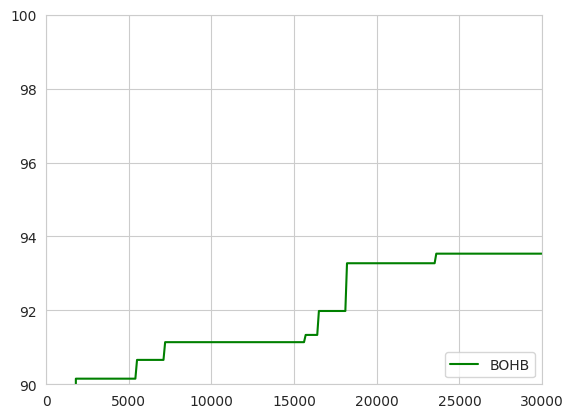

evaluate result_dict {'benchmark prediction': [38.28332500327898, 49.762756379863475, 58.2032010883934, 63.233043220167374, 66.79234569032373, 68.11357455463292, 71.58895361504018, 73.39341961439096, 74.32434321104706, 75.82552175298281, 76.71534640251488, 77.21159162306265, 77.20436813183213, 78.23281001641533, 78.5898456939818, 79.6368247965558, 79.7311859101805, 80.11048880594566, 80.0764398372376, 80.12340207617216, 79.6856641472803, 80.73613121600927, 80.86070745141465, 81.50366685556978, 81.97492769786675, 81.40306001729645, 81.31596900815997, 81.84060464507577, 82.08852493628609, 81.95175197998145, 82.596906462664, 81.7968321521961, 81.72352150292686, 83.14921361228451, 83.18084119295077, 83.11085779721449, 82.88766564825423, 82.5620890343846, 82.9240731405858, 83.43350353181796, 83.36541458557896, 83.60583549723304, 83.49089754140859, 83.84307827044923, 84.15377252794697, 84.04277568275191, 83.77519863417376, 83.9951128921178, 84.49902576260847, 84.1236732545647, 84.34541010022

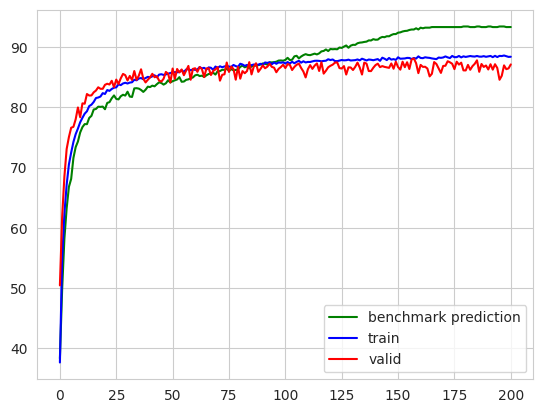

{'BOHB': {'accuracy': [90.1516911317044,
   90.65973271850622,
   91.13935598038536,
   91.3354413992893,
   91.98288764381384,
   93.27468733079112,
   93.53402710510667],
  'train_time': [1700, 5472, 7172, 15616, 16416, 18116, 23588]}}

In [ ]:
optimization_curves = {}
optimizer="BOHB"
search_space="nasbench211"

apply_optimizer_on_search_space(optimizer_name=optimizer, search_space_name=search_space, folder_to_save_results=drivefolder)

Now we can evaluate prediction of the query for NasBench211SearchSpace:

It approximate real learning curve much better then benchmark NasBench311SearchSpace. But it grows all along the curve.  My guess is that most of the dataset was acquired using the HyperBand principle and the model is overfitted on partially shaped leaning curves.

/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb311-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


np.random.seed: 0
accuracy 93.93349821553534 is reached with budget 284
accuracy 94.17865908462485 is reached with budget 1956
accuracy 94.30641575113103 is reached with budget 9480
optimization_curve {'BOHB': {'accuracy': [93.93349821553534, 94.17865908462485, 94.30641575113103], 'train_time': [284, 1956, 9480]}}


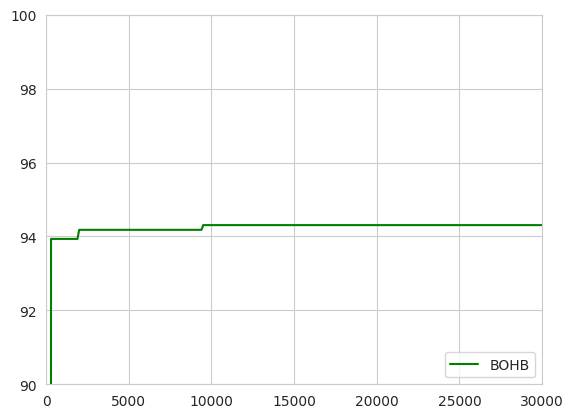

evaluate result_dict {'benchmark prediction': [44.29014231665751, 53.72734452663851, 59.59826310722281, 64.54639732914288, 66.79965919683173, 68.8406553703194, 72.23355991190257, 73.8463843169751, 74.41131393208065, 76.91193945261963, 77.0514045767235, 78.83583661552213, 79.5979659271056, 80.45313280541815, 80.73406494841421, 80.81663050511709, 81.4423367485786, 82.71335010007961, 82.79283916463227, 83.35806082205445, 82.96864199006316, 84.32650750814615, 84.50980365980922, 84.46964251053313, 84.78935679072065, 84.3686857549278, 85.23802950370907, 85.96391866400658, 85.27255252284391, 86.28777610127605, 86.06671281436661, 86.48772871809126, 86.74106707612486, 86.83074017086514, 87.12827761019155, 87.29079157020348, 87.20507175142889, 87.52416045251188, 87.82380957899672, 88.13773067462485, 88.0641072061328, 87.88466092469643, 88.90976244312017, 88.5215274217455, 88.53507948778645, 88.92614886929715, 88.7458615901453, 89.5523588076233, 89.45478002484444, 89.46848180803842, 89.6960672448

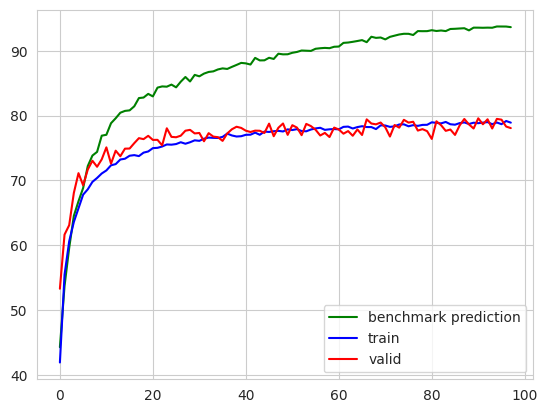

In [ ]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)
optimization_curves = {}
optimizer="BOHB"
search_space="nasbench311"

optimization_curves[search_space] = apply_optimizer_on_search_space(optimizer_name=optimizer, search_space_name=search_space, folder_to_save_results=drivefolder)

##### TTopt


TTOpt optimizer for NAS tasks can be created based on an existing optimizer by presenting the benchmark as a function to be optimized.

TTOpt should query the value of a function at specific points in the search space (architectures) for a specific epoch. Since the complete information about the learning curve was available for the BOHB, this is exactly what TTOpt will request.

The optimizer's budget can be minimized by using a cache and storing in it the values of the function that have already been requested before.

We will return 0 in that points of search space and just half of budget  where model is not defined of the benchmark 311.

At the end of July 2023 Andrei Chertkov (the owner of [ttopt repository](https://github.com/AndreiChertkov/ttopt)) published a new version of the optimizer in which the way of maxvol calculation has been changed.  


It seems to me this notebook would be incomplete without comparing two versions of TTopt. To be able to use both previous and current version of it I copied previous necessary ttopt_raw.py to the next cell.


In [ ]:
"""Multidimensional minimizer based on the cross-maximum-volume principle.

This module contains the main function "ttopt" that finds the approximate
minimum of the given multidimensional array (tensor), which can represent a
discretized multivariable function.

Note:
    For the task of finding the extremum of a function of many variables or
    multidimensional array, a wrapper class "TTOpt" (from "ttopt.py") could be
    used. It provides a set of methods for discretizing the function, caching
    previously requested values and logging intermediate results. In this case,
    a wrapper "TTOpt.comp_min" should be passed to the function "ttopt" as its
    first argument (the method "TTOpt.minimize" provides the related interface).

"""
try:
    from maxvolpy.maxvol import maxvol
    from maxvolpy.maxvol import rect_maxvol
    WITH_MAXVOLPY = True
except Exception as e:
    from teneva import maxvol
    from teneva import maxvol_rect as rect_maxvol
    WITH_MAXVOLPY = False


import numpy as np


def ttopt(f, n, rmax=5, evals=None, Y0=None, fs_opt=1., add_opt_inner=True, add_opt_outer=False, add_opt_rect=False, add_rnd_inner=False, add_rnd_outer=False, J0=None, is_max=False):
    """Find the minimum element of the implicitly given multidimensional array.

    This function computes the minimum of the implicitly given d-dimensional
    (d >= 2) array (tensor). The adaptive method based on the tensor train (TT)
    approximation and the cross-maximum-volume principle are used.

    Args:
        f (function): the function that returns tensor values for the given set
            of the indices. Its arguments are (I, i_min, y_min, opt_min), where
            "I" represents several multi-indices (samples) for calculation (it
            is 2D np.ndarray of the shape [samples, dimensions]), "i_min"
            represents the current multi-index of the argmin approximation (it
            is 1D np.ndarray of the shape [dimensions]; note that while the
            first call it will be None), "y_min" represents the current
            approximated minimum of the tensor (it is float; note that while
            the first call it will be None) and "opt_min" is the value of the
            auxiliary quantity corresponding to the multi-index "i_min" (it is
            used for debugging and in specific parallel calculations). The
            output of the function should be the corresponding values in the
            given indices (1D np.ndarray of the shape [samples]) and related
            values of the auxiliary quantities at the requested points (1D
            np.ndarray of the shape [samples] of any). If the function returns
            None instead of the tensor values, then the algorithm will be
            interrupted and the current approximation will be returned.
        n (list of len d of int): number of grid points for every dimension
            (i.e., the shape of the tensor). Note that the tensor must have a
            dimension of at least 2.
        rmax (int): maximum used rank for unfolding matrices.
        evals (int or float): number of available calls to function (i.e.,
            computational budget). If it is None, then the algorithm will run
            until the target function returns a None instead of the y-value.
        Y0 (list of 3D np.ndarrays): optional initial tensor in the TT-format
            (it should be represented as a list of the TT-cores). If it is not
            specified, then a random TT-tensor with TT-rank "rmax" will be used.
        fs_opt (float): the parameter of the smoothing function. If it is None,
            then "arctan" function will be used. Otherwise, the function
            "exp(-1 * fs_opt * (p - p0))" will be used.

    Returns:
        [np.ndarray, float]: the multi-index that gives the minimum value of the
        tensor (it is 1D np.ndarray of length "d" of int; i.e., "i_min") and
        the minimum value of the tensor (it is float; i.e., "y_min") that
        corresponds to the multi-index "i_min".

    """
    # Number of dimensions:
    d = len(n)

    # Number of possible function calls:
    evals = int(evals) if evals else None

    # Grid:
    Jg_list = [np.reshape(np.arange(k), (-1, 1)) for k in n]

    # Prepare initial multi-indices for all unfolding matrices:
    if J0 is None:
        Y0, r = ttopt_init(n, rmax, Y0, with_rank=True)
        J_list = [None] * (d + 1)
        for i in range(d - 1):
            J_list[i+1] = _iter(Y0[i], J_list[i], Jg_list[i], l2r=True)
    else:
        J_list = J0
        r = [1] + [J.shape[0] for J in J_list[1:-1]] + [1]

    i_min = None         # Approximation of argmin for tensor
    y_min = None         # Approximation of min for tensor (float('inf'))
    opt_min = None       # Additional option related to i_min

    eval = 0             # Number of performed calls to function
    iter = 0             # Iteration (sweep) number
    i = d - 1            # Index of the current core (0, 1, ..., d-1)
    l2r = False          # Core traversal direction (left <-> right)

    while True:
        # We select multi-indices [samples, d], which will requested from func:
        I = _merge(J_list[i], J_list[i+1], Jg_list[i])

        # We check if the maximum number of requests has been exceeded:
        eval_curr = I.shape[0]
        if evals is not None and eval + eval_curr > evals:
            I = I[:(evals-eval), :]

        # We compute the function of interest "f" in the sample points I:
        y, opt = f(I, i_min, y_min, opt_min)

        # Function "f" can return None to interrupt the algorithm execution:
        if y is None:
            return i_min, y_min

        # We find and check the minimum value on a set of sampled points:
        i_min, y_min, opt_min = ttopt_find(I, y, opt, i_min, y_min, opt_min,
            is_max)

        # If the max number of requests exceeded, we interrupt the algorithm:
        eval += y.size
        if evals is not None and eval >= evals:
            return i_min, y_min

        # If computed points less then requested, we interrupt the algorithm:
        if y.shape[0] < I.shape[0]:
            return i_min, y_min

        # We transform sampled points into "core tensor" and smooth it out:
        Z = _reshape(y, (r[i], n[i], r[i + 1]))
        if not is_max:
            Z = ttopt_fs(Z, y_min, fs_opt)

        # We perform iteration:
        if l2r and i < d - 1:
            J_list[i+1] = _iter(Z, J_list[i], Jg_list[i], l2r,
                add_opt_inner, add_opt_rect, add_rnd_inner)
            if add_opt_outer:
                J_list[i+1] = _add_row(J_list[i+1], i_min[:(i+1)])
            if add_rnd_outer:
                J_list[i+1] = _add_random(J_list[i+1], n[:(i+1)])
            r[i+1] = J_list[i+1].shape[0]
        if not l2r and i > 0:
            J_list[i] = _iter(Z, J_list[i+1], Jg_list[i], l2r,
                add_opt_inner, add_opt_rect, add_rnd_inner)
            if add_opt_outer:
                J_list[i] = _add_row(J_list[i], i_min[i:])
            if add_rnd_outer:
                J_list[i] = _add_random(J_list[i], n[i:])
            r[i] = J_list[i].shape[0]

        # We update the current core index:
        i, iter, l2r = _update_iter(d, i, iter, l2r)

    return i_min, y_min


def ttopt_find(I, y, opt, i_min, y_min, opt_min, is_max=False):
    """Find the minimum value on a set of sampled points."""
    if is_max:
        ind = np.argmax(y)
    else:
        ind = np.argmin(y)
    y_min_curr = y[ind]

    if is_max and y_min is not None and y_min_curr <= y_min:
        return i_min, y_min, opt_min

    if not is_max and y_min is not None and y_min_curr >= y_min:
        return i_min, y_min, opt_min

    return I[ind, :], y_min_curr, opt[ind]


def ttopt_fs(y, y0=0., opt=1.):
    """Smooth function that transforms max to min."""
    if opt is None or opt == 0:
        return np.pi/2 - np.arctan(y - y0)
    else:
        return np.exp(opt * (y0 - y))


def ttopt_init(n, rmax, Y0=None, with_rank=False):
    """Build initial approximation for the main algorithm."""
    d = len(n)

    r = [1]
    for i in range(1, d):
        r.append(min(rmax, n[i-1] * r[i-1]))
    r.append(1)

    if Y0 is None:
        Y0 = [np.random.randn(r[i], n[i], r[i + 1]) for i in range(d)]
    if with_rank:
        return Y0, r
    else:
        return Y0


def _add_random(J, n):
    i_rnd = [np.random.choice(k) for k in n]
    i_rnd = np.array(i_rnd, dtype=int)
    J_new = np.vstack((J, i_rnd.reshape(1, -1)))
    return J_new


def _add_row(J, i_new):
    J_new = np.vstack((J, i_new.reshape(1, -1)))
    return J_new


def _iter(Z, J, Jg, l2r=True, add_opt_inner=True, add_opt_rect=False, add_rnd_inner=False):
    r1, n, r2 = Z.shape

    Z = _reshape(Z, (r1 * n, r2)) if l2r else _reshape(Z, (r1, n * r2)).T

    Q, R = np.linalg.qr(Z)

    ind = _maxvol(Q, is_rect=add_opt_rect)

    if add_opt_inner:
        i_max, j_max = np.divmod(np.abs(Z).argmax(), Z.shape[1])
        if not i_max in ind:
            ind[-1] = i_max

    if add_rnd_inner and len(ind) > 1:
        i_rnd = np.random.choice(Z.shape[0])
        if not i_rnd in ind:
            ind[-2] = i_rnd

    J_new = _stack(J, Jg, l2r)
    J_new = J_new[ind, :]

    return J_new


def _maxvol(A, tol=1.001, max_iters=1000, is_rect=False):
    n, r = A.shape
    if n <= r:
        return np.arange(n, dtype=int)

    if WITH_MAXVOLPY:
        return _maxvol_maxvolpy(A, tol, max_iters, is_rect)
    else:
        return _maxvol_teneva(A, tol, max_iters, is_rect)


def _maxvol_maxvolpy(A, tol=1.001, max_iters=1000, is_rect=False):
    if is_rect:
        tol_rect = 1.
        kickrank = 1
        rf = 1.

        if kickrank is not None and rf is not None:
            maxK = A.shape[1] + kickrank + rf
        else:
            maxK = None

        return rect_maxvol(A, tol=tol_rect, min_add_K=kickrank, maxK=maxK,
            start_maxvol_iters=10, identity_submatrix=False)[0]
    else:
        return maxvol(A, tol=tol, max_iters=max_iters)[0]


def _maxvol_teneva(A, tol=1.001, max_iters=1000, is_rect=False):
    if is_rect:
        return rect_maxvol(A, e=1., dr_min=1, dr_max=2)[0]
    else:
        return maxvol(A, e=tol, k=max_iters)[0]


def _merge(J1, J2, Jg):
    r1 = J1.shape[0] if J1 is not None else 1
    r2 = J2.shape[0] if J2 is not None else 1
    n = Jg.shape[0]

    I = np.kron(np.kron(_ones(r2), Jg), _ones(r1))

    if J1 is not None:
        J1_ = np.kron(_ones(n * r2), J1)
        I = np.hstack((J1_, I))

    if J2 is not None:
        J2_ = np.kron(J2, _ones(r1 * n))
        I = np.hstack((I, J2_))

    return I


def _ones(k, m=1):
    return np.ones((k, m), dtype=int)


def _reshape(A, n):
    return np.reshape(A, n, order='F')


def _stack(J, Jg, l2r=True):
    r = J.shape[0] if J is not None else 1
    n = Jg.shape[0]

    J_new = np.kron(Jg, _ones(r)) if l2r else np.kron(_ones(r), Jg)

    if J is not None:
        J_old = np.kron(_ones(n), J) if l2r else np.kron(J, _ones(n))
        J_new = np.hstack((J_old, J_new)) if l2r else np.hstack((J_new, J_old))

    return J_new


def _update_iter(d, i, iter, l2r):
    i += 1 if l2r else -1

    if i == -1 or i == d:
        iter += 1
        l2r = not l2r
        i += 1 if l2r else -1

    return i, iter, l2r


In [ ]:
# from ttopt.ttopt_raw import ttopt
# from ttopt.ttopt_raw import ttopt_find
from naslib.search_spaces.nasbench201.conversions import convert_op_indices_to_naslib, convert_naslib_to_op_indices, convert_naslib_to_str


class TTopt_old():
    """Tensor Train optimizer basedon the tensor train (TT) approximation and
    cross-maximum-volume principle.
    """

    def __init__(self, config):
        self.config = config
        if self.config.search_space in ["nasbench201", "nasbench211"]:
            self.f = self.nb211func
            self.d = 6    # number of edges to set operation on (function dimensions)
            a = 0         # min index of operation to set on
            b = 4         # min index of operation to set on
            self.rmax = 1 # maximum TT-rank while cross-like iterations
        elif self.config.search_space == "darts":
            self.f = self.nb311func
            self.d = 28   # number of edges to set operation on (function dimensions)
            a = -1        # min index of operation to set on
            b = 6         # min index of operation to set on
            self.rmax = 9 # maximum TT-rank while cross-like iterations
        self.n = np.ones(self.d, dtype=int) * (b-a+1)
        self.history = torch.nn.ModuleList()
        self.cache = {}     # Cache for the results of requests to function
        self.number_of_search_spaces_to_check = 0
        self.number_of_successful_queries = 0

    def adapt_search_space(self, search_space, scope=None, dataset_api=None):
        assert search_space.QUERYABLE, "Hyperband_simple is currently only implemented for benchmarks."
        self.search_space = search_space.clone()
        self.dataset_api = dataset_api

    def _update_history(self, model):
        if len(self.history):
            if self.history[0].accuracy < model.accuracy:
                self.history[0] = model
            else:
              return
        else:
            self.history.append(model)
        self.optimization_curve["accuracy"].append(model.accuracy)
        self.optimization_curve["train_time"].append(self.search_time)
        print("accuracy {} is reached with budget {}".format(model.accuracy, self.search_time))

    def nb211func(self, op_indices):
        """
        op_indices values will be equal to OP_NAMES list from
        naslib.search_spaces.nasbench201.conversions
        """
        # print("nb211func(self, op_indices)")
        search_space = self.search_space.clone()
        op_indices = op_indices.astype(np.int_)
        # print("nb211func(self, op_indices)", op_indices)
        convert_op_indices_to_naslib(op_indices, search_space)
        # print("nb211func(self, op_indices) query")
        learning_curve = search_space.query(dataset_api=self.dataset_api, full_lc=True)
        # print("nb211func(self, op_indices)" , "op_indices")
        search_space.accuracy = learning_curve.max()
        self.search_time += len(learning_curve)
        self._update_history(search_space)
        # print("nb211func(self, op_indices)", y)
        y = search_space.accuracy if self.search_budgets > self.search_time else None
        return y

    def nb311func(self, op_indices):
        """
        Let's consider negative values of operations on edges as edges to be deleted.
        Positive values will be equal to OPS list indices from
        naslib.search_spaces.darts.conversions.convert_genotype_to_compact().
        Let's count budget fully at those points where query result was successful.
        Let's return 0 in that points of search space and just one of budget
        where model is not defined.
        """
        def convert_indices_to_cell_compact(indices):
            edges = ((1, 3), (2, 3), (1, 4), (2, 4), (3, 4), (1, 5), (2, 5), (3, 5), (4, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6))
            compact = []
            for op_ind, edge in zip(indices, edges):
                if op_ind<0: continue
                compact.append((edge[0]-1, op_ind))
            return tuple(compact)
        op_indices = op_indices-1
        compact = []
        number_of_ops_in_a_cell = 14
        for start_ind in range(0, len(op_indices), number_of_ops_in_a_cell):
            cell_indices = op_indices[start_ind:start_ind+number_of_ops_in_a_cell]
            if np.where(cell_indices>=0, 1, 0).sum() != 8:
              self.search_time += 1
              return 0
            cell_compact = convert_indices_to_cell_compact(cell_indices)
            compact.append(cell_compact)
        compact = tuple(compact)
        self.number_of_search_spaces_to_check += 1
        search_space = self.search_space.clone()
        search_space.compact = compact
        convert_compact_to_naslib(compact, search_space)
        learning_curve = search_space.query(dataset_api=self.dataset_api, full_lc=True)
        if isinstance(learning_curve, np.ndarray ) :
            self.number_of_successful_queries += 1
            search_space.accuracy = learning_curve.max()
            self.search_time += len(learning_curve)
            self._update_history(search_space)
            y = search_space.accuracy if self.search_budgets > self.search_time else None
            return y
        else:
            self.search_time += 1
            return 0

    def search(self, search_budgets):
        self.optimization_curve = {"accuracy": [], "train_time": []}
        self.search_budgets = search_budgets
        self.search_time = 0
        ttopt(self.calc, self.n, self.rmax, add_rnd_inner=True, add_rnd_outer=True, is_max=True)
        return self.optimization_curve

    def get_final_architecture(self):
        return self.history[0]


    def calc(self, I, i_min, y_min, opt_min):
        Y= []
        for i in I:
            s = self.i2s(i.astype(int).tolist())
            if not s in self.cache:
                y = self.f(i)
                if y is None : break
                self.cache[s] = y
            else:
                y = self.cache[s]
            Y.append(y)
        _opt = [None for _ in range(len(Y))]
        if len(Y): return np.array(Y), _opt
        else: return None, _opt

    def i2s(self, i):
        """Transform array of int like [1, 2, 3] into string like '1-2-3'."""
        return '-'.join([str(v) for v in i])

    def s2i(self, s):
        """Transforms string like '1-2-3' into array of int like [1, 2, 3]."""
        return np.array([int(v) for v in s.split('-')], dtype=int)



To be able to use current version of ttopt_raw.py I import the function "ttopt" with alias "ttopt_updated".

In [ ]:
from ttopt.ttopt_raw import ttopt as ttopt_updated
from naslib.search_spaces.nasbench201.conversions import convert_op_indices_to_naslib, convert_naslib_to_op_indices, convert_naslib_to_str


class TTopt_new():
    """Tensor Train optimizer basedon the tensor train (TT) approximation and
    cross-maximum-volume principle.
    """

    def __init__(self, config):
        self.config = config
        self.seed = config.search.seed
        if self.config.search_space in ["nasbench201", "nasbench211"]:
            self.f = self.nb211func
            self.d = 6    # number of edges to set operation on (function dimensions)
            a = 0         # min index of operation to set on
            b = 4         # min index of operation to set on
            self.rmax = 1 # maximum TT-rank while cross-like iterations
        elif self.config.search_space == "darts":
            self.f = self.nb311func
            self.d = 28   # number of edges to set operation on (function dimensions)
            a = -1        # min index of operation to set on
            b = 6         # min index of operation to set on
            self.rmax = 9 # maximum TT-rank while cross-like iterations
        self.n = np.ones(self.d, dtype=int) * (b-a+1)
        self.history = torch.nn.ModuleList()
        self.cache = {}     # Cache for the results of requests to function
        self.number_of_search_spaces_to_check = 0
        self.number_of_successful_queries = 0

    def adapt_search_space(self, search_space, scope=None, dataset_api=None):
        assert search_space.QUERYABLE, "Hyperband_simple is currently only implemented for benchmarks."
        self.search_space = search_space.clone()
        self.dataset_api = dataset_api

    def _update_history(self, model):
        if len(self.history):
            if self.history[0].accuracy < model.accuracy:
                self.history[0] = model
            else:
              return
        else:
            self.history.append(model)
        self.optimization_curve["accuracy"].append(model.accuracy)
        self.optimization_curve["train_time"].append(self.search_time)
        print("accuracy {} is reached with budget {}".format(model.accuracy, self.search_time))

    def nb211func(self, op_indices):
        """
        op_indices values will be equal to OP_NAMES list from
        naslib.search_spaces.nasbench201.conversions
        """
        search_space = self.search_space.clone()
        op_indices = op_indices.astype(np.int_)
        convert_op_indices_to_naslib(op_indices, search_space)
        learning_curve = search_space.query(dataset_api=self.dataset_api, full_lc=True)
        search_space.accuracy = learning_curve.max()
        self.search_time += len(learning_curve)
        self._update_history(search_space)
        y = search_space.accuracy if self.search_budgets > self.search_time else None
        return y

    def nb311func(self, op_indices):
        """
        Let's consider negative values of operations on edges as edges to be deleted.
        Positive values will be equal to OPS list indices from
        naslib.search_spaces.darts.conversions.convert_genotype_to_compact().
        Let's count budget fully at those points where query result was successful.
        Let's return 0 in that points of search space and just one of budget
        where model is not defined.
        """
        def convert_indices_to_cell_compact(indices):
            edges = ((1, 3), (2, 3), (1, 4), (2, 4), (3, 4), (1, 5), (2, 5), (3, 5), (4, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6))
            compact = []
            for op_ind, edge in zip(indices, edges):
                if op_ind<0: continue
                compact.append((edge[0]-1, op_ind))
            return tuple(compact)
        op_indices = op_indices-1
        compact = []
        number_of_ops_in_a_cell = 14
        for start_ind in range(0, len(op_indices), number_of_ops_in_a_cell):
            cell_indices = op_indices[start_ind:start_ind+number_of_ops_in_a_cell]
            if np.where(cell_indices>=0, 1, 0).sum() != 8:
              self.search_time += 1
              return 0
            cell_compact = convert_indices_to_cell_compact(cell_indices)
            compact.append(cell_compact)
        compact = tuple(compact)
        self.number_of_search_spaces_to_check += 1
        search_space = self.search_space.clone()
        search_space.compact = compact
        convert_compact_to_naslib(compact, search_space)
        learning_curve = search_space.query(dataset_api=self.dataset_api, full_lc=True)
        if isinstance(learning_curve, np.ndarray ) :
            self.number_of_successful_queries += 1
            search_space.accuracy = learning_curve.max()
            self.search_time += len(learning_curve)
            self._update_history(search_space)
            y = search_space.accuracy if self.search_budgets > self.search_time else None
            return y
        else:
            self.search_time += 1
            return 0

    def search(self, search_budgets):
        self.optimization_curve = {"accuracy": [], "train_time": []}
        self.search_budgets = search_budgets
        self.search_time = 0
        ttopt_updated(self.calc, self.n, self.rmax, add_rnd_inner=True, add_rnd_outer=True, is_max=True, seed=self.seed)
        return self.optimization_curve

    def get_final_architecture(self):
        return self.history[0]


    def calc(self, I, i_min, y_min, opt_min):
        Y= []
        for i in I:
            s = self.i2s(i.astype(int).tolist())
            if not s in self.cache:
                y = self.f(i)
                if y is None : break
                self.cache[s] = y
            else:
                y = self.cache[s]
            Y.append(y)
        _opt = [None for _ in range(len(Y))]
        if len(Y): return np.array(Y), _opt
        else: return None, _opt

    def i2s(self, i):
        """Transform array of int like [1, 2, 3] into string like '1-2-3'."""
        return '-'.join([str(v) for v in i])

    def s2i(self, s):
        """Transforms string like '1-2-3' into array of int like [1, 2, 3]."""
        return np.array([int(v) for v in s.split('-')], dtype=int)



/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb311-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


np.random.seed: 8
accuracy 92.9105112144599 is reached with budget 870702
accuracy 93.34668320597675 is reached with budget 871105
accuracy 93.40522388311611 is reached with budget 871792
accuracy 93.77408784531801 is reached with budget 873166
accuracy 93.92499325187276 is reached with budget 886162
accuracy 93.9300325047531 is reached with budget 889411
optimization_curve {'TTopt': {'accuracy': [92.9105112144599, 93.34668320597675, 93.40522388311611, 93.77408784531801, 93.92499325187276, 93.9300325047531], 'train_time': [870702, 871105, 871792, 873166, 886162, 889411]}}


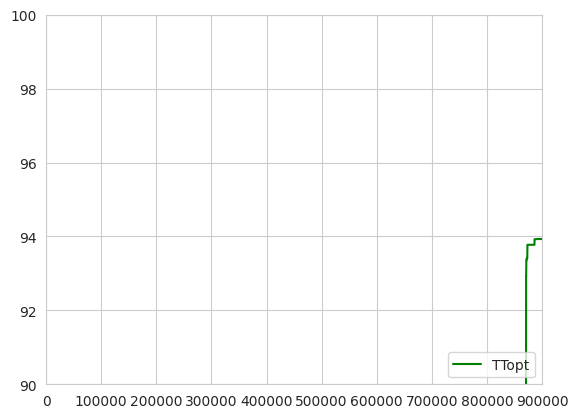

evaluate result_dict {'benchmark prediction': [34.72571566900211, 44.18904093276653, 51.12017875322284, 55.55843130807274, 58.96655270509227, 61.978017434593234, 65.57394633176838, 67.54075349014255, 68.58706758111164, 70.51881177642065, 72.0273034291476, 73.00025097117974, 74.08989666717392, 75.69047721487487, 75.85901089236108, 76.12448843467625, 77.57227316095272, 78.58386638222491, 78.8492472493829, 79.79898390636538, 79.16174399365403, 80.77487094508147, 81.20715184113452, 82.04013872145516, 81.77329555487361, 82.09395003851462, 82.4645315802022, 83.61525237311879, 83.05786185424765, 83.91582580986501, 83.88152399584382, 84.46754672667886, 84.68368740725076, 84.79188299857353, 85.20336542589023, 85.22343065671207, 85.38934213479625, 85.93105815080315, 86.15208468816427, 86.66789363217309, 86.44820906487269, 86.58890917443298, 87.51802714880145, 87.33710124775406, 87.33412229851865, 87.62967382848167, 87.53569093897147, 88.29590000280984, 88.14257367595464, 88.32018323720189, 88.49

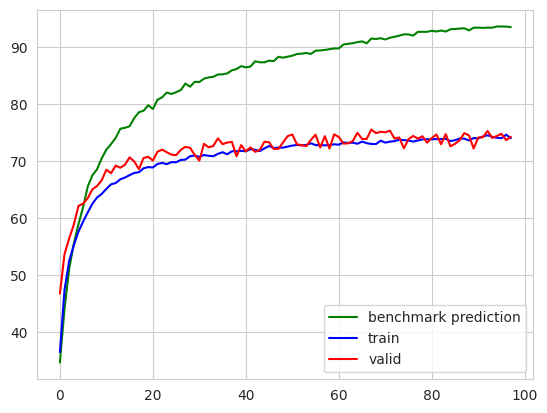

In [ ]:
optimization_curves = {}
optimizer="TTopt"
search_space="nasbench311"

optimization_curves[search_space] = apply_optimizer_on_search_space(seed = 8, search_budgets = 900000, optimizer_name=optimizer, search_space_name=search_space, folder_to_save_results=drivefolder)


/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb211-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


np.random.seed: 0
accuracy 88.33049556706482 is reached with budget 201
accuracy 88.38769861117558 is reached with budget 402
accuracy 89.39926684345642 is reached with budget 603
accuracy 90.17502530107339 is reached with budget 1407
accuracy 92.38936000905795 is reached with budget 4623
accuracy 93.12412288455347 is reached with budget 6633
accuracy 93.71245701582781 is reached with budget 8442
accuracy 94.13750587106468 is reached with budget 19296
optimization_curve {'TTopt': {'accuracy': [88.33049556706482, 88.38769861117558, 89.39926684345642, 90.17502530107339, 92.38936000905795, 93.12412288455347, 93.71245701582781, 94.13750587106468], 'train_time': [201, 402, 603, 1407, 4623, 6633, 8442, 19296]}}


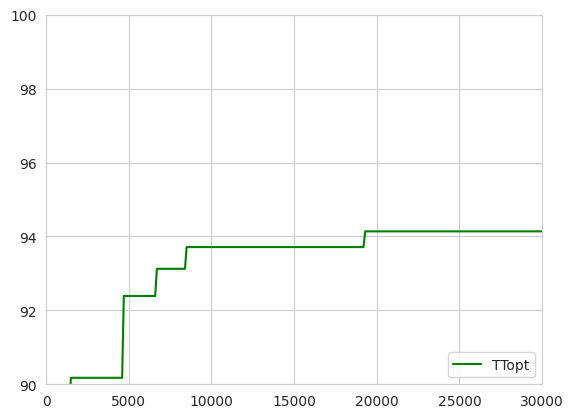

evaluate result_dict {'benchmark prediction': [38.28332500327898, 49.762756379863475, 58.2032010883934, 63.233043220167374, 66.79234569032373, 68.11357455463292, 71.58895361504018, 73.39341961439096, 74.32434321104706, 75.82552175298281, 76.71534640251488, 77.21159162306265, 77.20436813183213, 78.23281001641533, 78.5898456939818, 79.6368247965558, 79.7311859101805, 80.11048880594566, 80.0764398372376, 80.12340207617216, 79.6856641472803, 80.73613121600927, 80.86070745141465, 81.50366685556978, 81.97492769786675, 81.40306001729645, 81.31596900815997, 81.84060464507577, 82.08852493628609, 81.95175197998145, 82.596906462664, 81.7968321521961, 81.72352150292686, 83.14921361228451, 83.18084119295077, 83.11085779721449, 82.88766564825423, 82.5620890343846, 82.9240731405858, 83.43350353181796, 83.36541458557896, 83.60583549723304, 83.49089754140859, 83.84307827044923, 84.15377252794697, 84.04277568275191, 83.77519863417376, 83.9951128921178, 84.49902576260847, 84.1236732545647, 84.34541010022

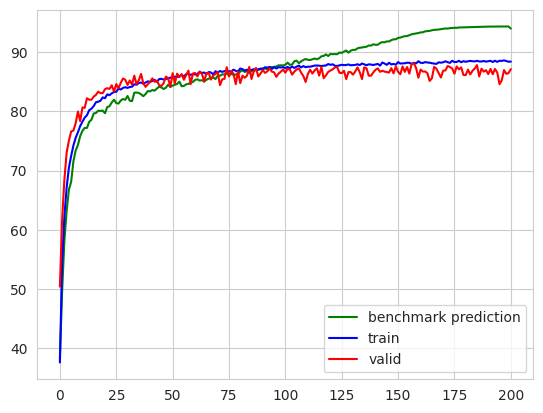

In [ ]:
optimization_curves = {}
optimizer="TTopt"
search_space="nasbench211"

optimization_curves[search_space] = apply_optimizer_on_search_space(optimizer_name=optimizer, search_space_name=search_space, folder_to_save_results=drivefolder)

/content/gdrive/MyDrive/MachineLearning/NAS/checkpoints/nb211-v0.5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RegressorChain from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


set_seed()  np.random.seed: 0
accuracy 87.3242462312246 is reached with budget 201
accuracy 91.8997171364501 is reached with budget 603
accuracy 92.75010457054933 is reached with budget 3015
accuracy 94.33142289539508 is reached with budget 8040
accuracy 96.43867825432375 is reached with budget 71355
accuracy 97.44454137291461 is reached with budget 77787
optimization_curve {'TTopt': {'accuracy': [87.3242462312246, 91.8997171364501, 92.75010457054933, 94.33142289539508, 96.43867825432375, 97.44454137291461], 'train_time': [201, 603, 3015, 8040, 71355, 77787]}}


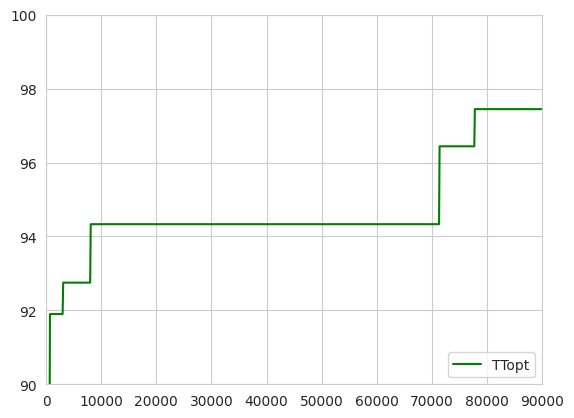

evaluate result_dict {'benchmark prediction': [38.27327341187917, 49.605218785450134, 57.97084831199556, 63.23379075565424, 66.98032615786686, 68.67033850945683, 72.53734976332515, 74.30937615711284, 75.53995975594864, 77.17433359989028, 78.22737999536486, 78.77919889442394, 78.86543683277996, 80.10201972859161, 80.73810407281965, 81.62056658711224, 81.72586781706518, 82.0642558010691, 82.26730312011262, 82.36645521795303, 81.81843619863056, 82.88257196096002, 82.91182812655735, 83.54120229143884, 84.18116681901682, 83.54700408951598, 83.43189228197942, 84.00449096303248, 84.19809358584334, 84.19208417136474, 84.85276788647228, 84.03913151752911, 83.92655169903973, 85.3677107356386, 85.41976016228189, 85.37148326662215, 85.01228425845132, 84.7623989563731, 85.15042952102506, 85.67443588251591, 85.50172176872788, 85.8135941002189, 85.78217713338748, 86.12680505283986, 86.38536798857423, 86.23489158081017, 85.82613295973782, 86.18054622333163, 86.70730873983369, 86.31602960008773, 86.611

100%|██████████| 170498071/170498071 [00:01<00:00, 105058134.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Going to train model from 96 to 201 epochs


<ipython-input-19-93e823f842d3>:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(start_epoch, epochs), desc='training '):


training :   0%|          | 0/105 [00:00<?, ?it/s]

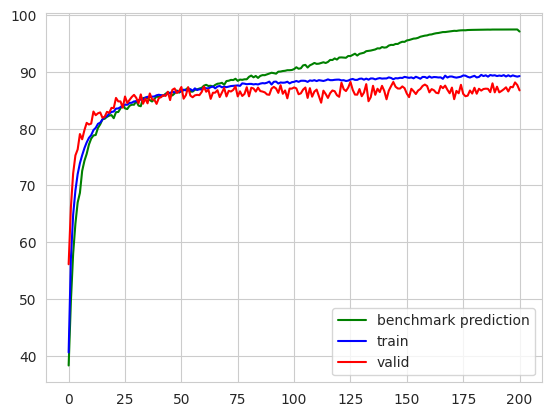

In [ ]:
optimization_curves = {}
optimizer="TTopt"
search_space="nasbench211"

optimization_curves[search_space] = apply_optimizer_on_search_space(search_budgets = 90000, optimizer_name=optimizer, search_space_name=search_space, folder_to_save_results=drivefolder)

##### Compare Optimizers

In [ ]:
# optimizers_list=["BOHB", "TTopt"]
optimizers_list=["TTopt_old", "TTopt_new"]
# search_spaces_list=["nasbench211", "nasbench311"]
# search_budgets_list=[30000, 30000]
search_spaces_list=["nasbench211"]
search_budgets_list=[150000]


for seed in range(0, 10):
  for search_space, budget in zip(search_spaces_list, search_budgets_list):
    for optimizer in optimizers_list:
        start = time.time()
        apply_optimizer_on_search_space(optimizer_name=optimizer, search_space_name=search_space,
                                folder_to_save_results=drivefolder,optimization_curve_file="optimization_curves.csv",
                                seed = seed, search_budgets = budget ,build_plots=False)
        print("time taken for 1 iteretion:", time.time()-start)

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

BEST_POSSIBLE_ACCURACY_ON_NB211 = 97.44454137291461

def build_plot_from_df(df, color_legend=None, title="", y_min=90, with_std=True):
    df = df.groupby(by='optimizer')
    number_o_subplots = len(df)
    color_legend = {m: cl  for m, cl in zip(df.indices.keys(), ["r","g","b","m","c","y"])}
    plt.figure().set_figwidth(33)
    plots = []
    for (n , n_df), i in zip(df, range(number_o_subplots) ):
        n_df_mean = n_df.mean()
        n_df_std = n_df.std()
        x = n_df_mean.keys()
        plt.plot(x, n_df_mean, color=color_legend[n], label=n)
        if with_std:
            plt.fill_between(x,  n_df_mean-n_df_std, n_df_mean+n_df_std, alpha=.3, linewidth=0, color=color_legend[n])
    plt.grid()
    plt.xticks([x[0], x[len(x)//2],  x[-1]])
    plt.title(title)
    plt.legend()
    plt.ylim(ymax = 100, ymin = y_min)
    plt.show()

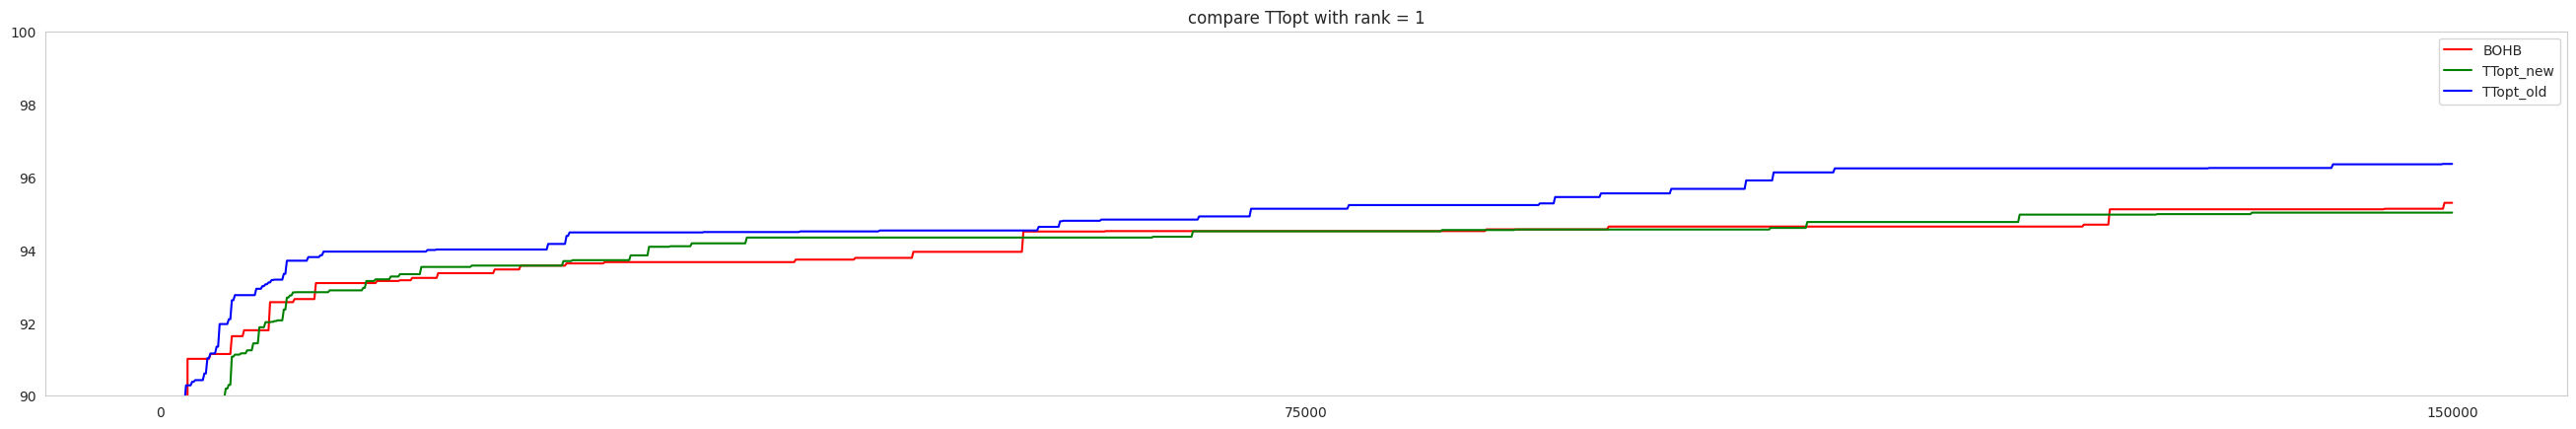

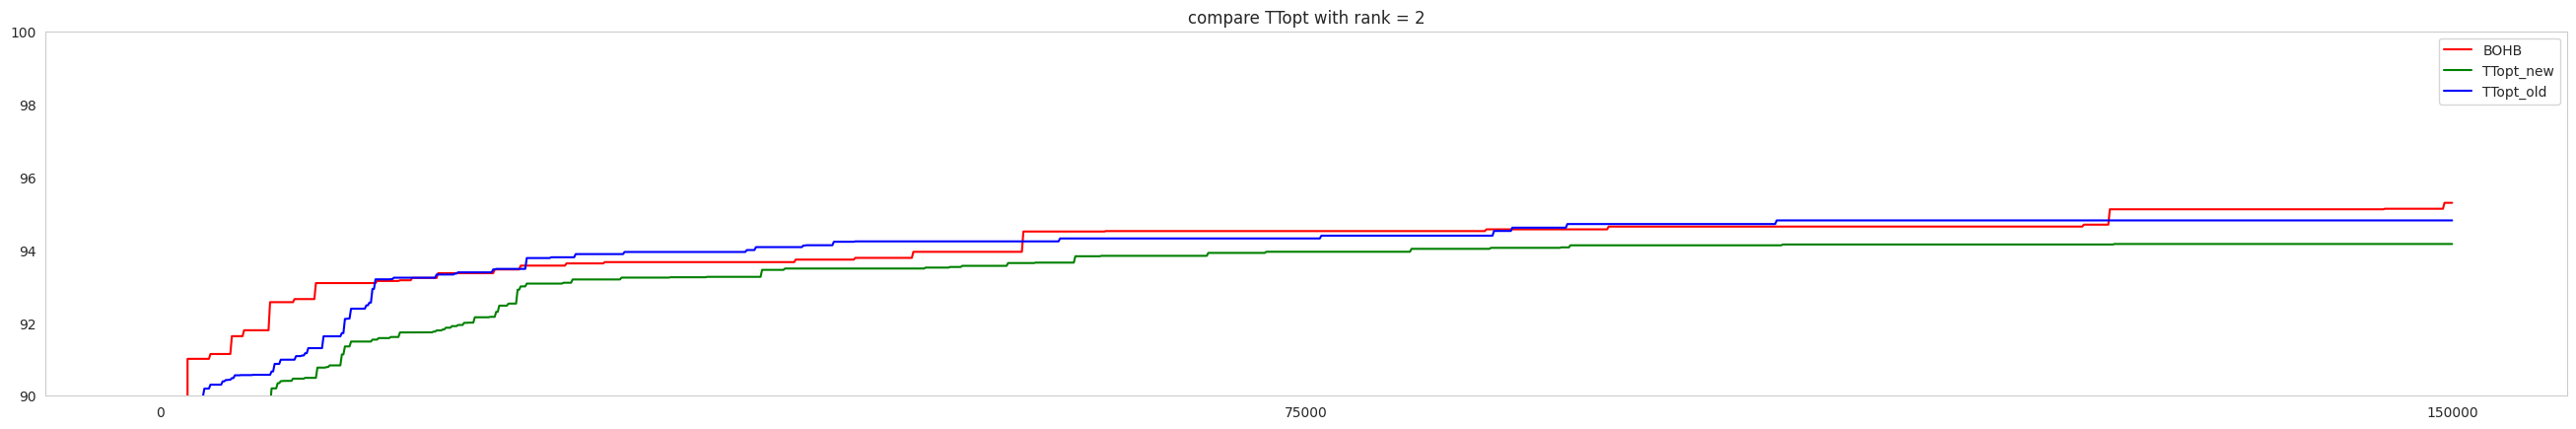

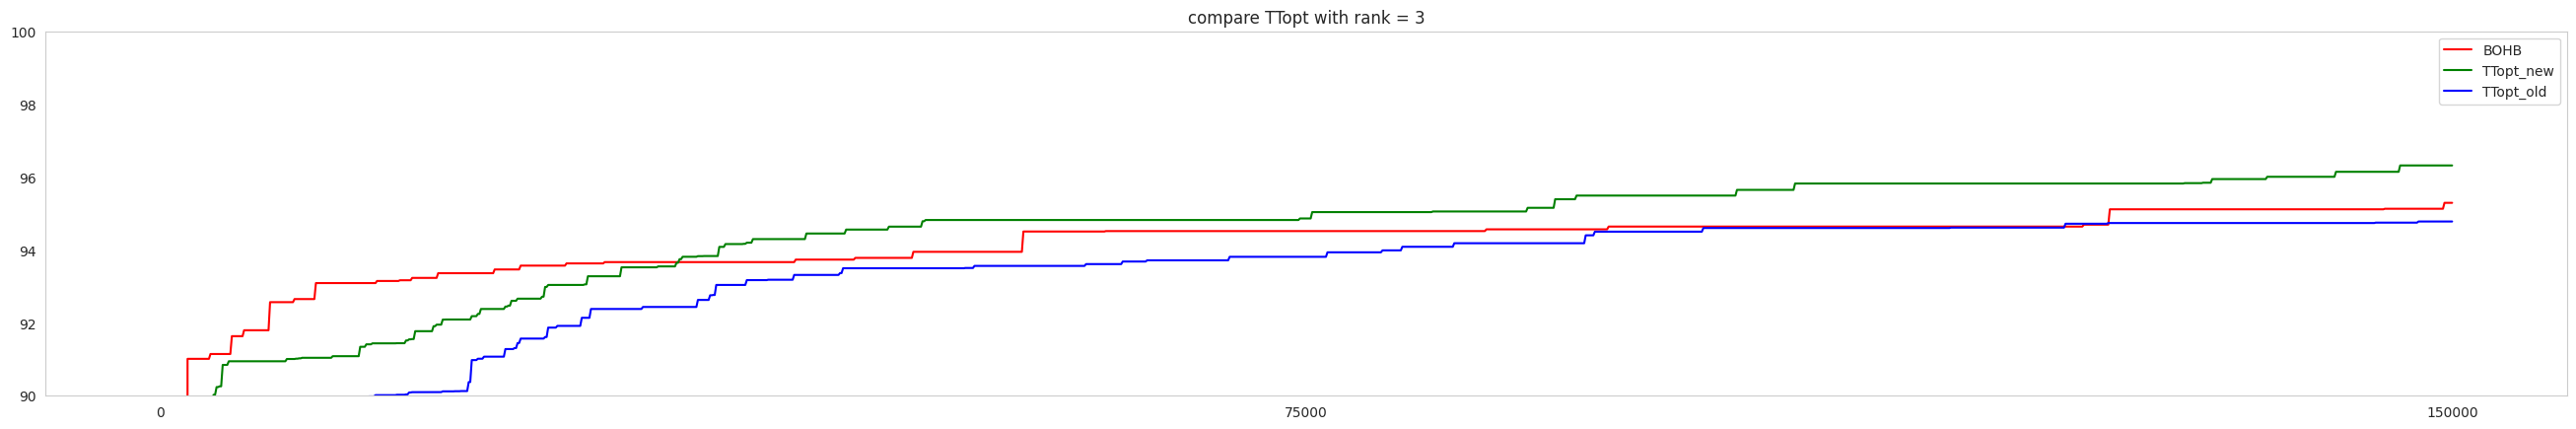

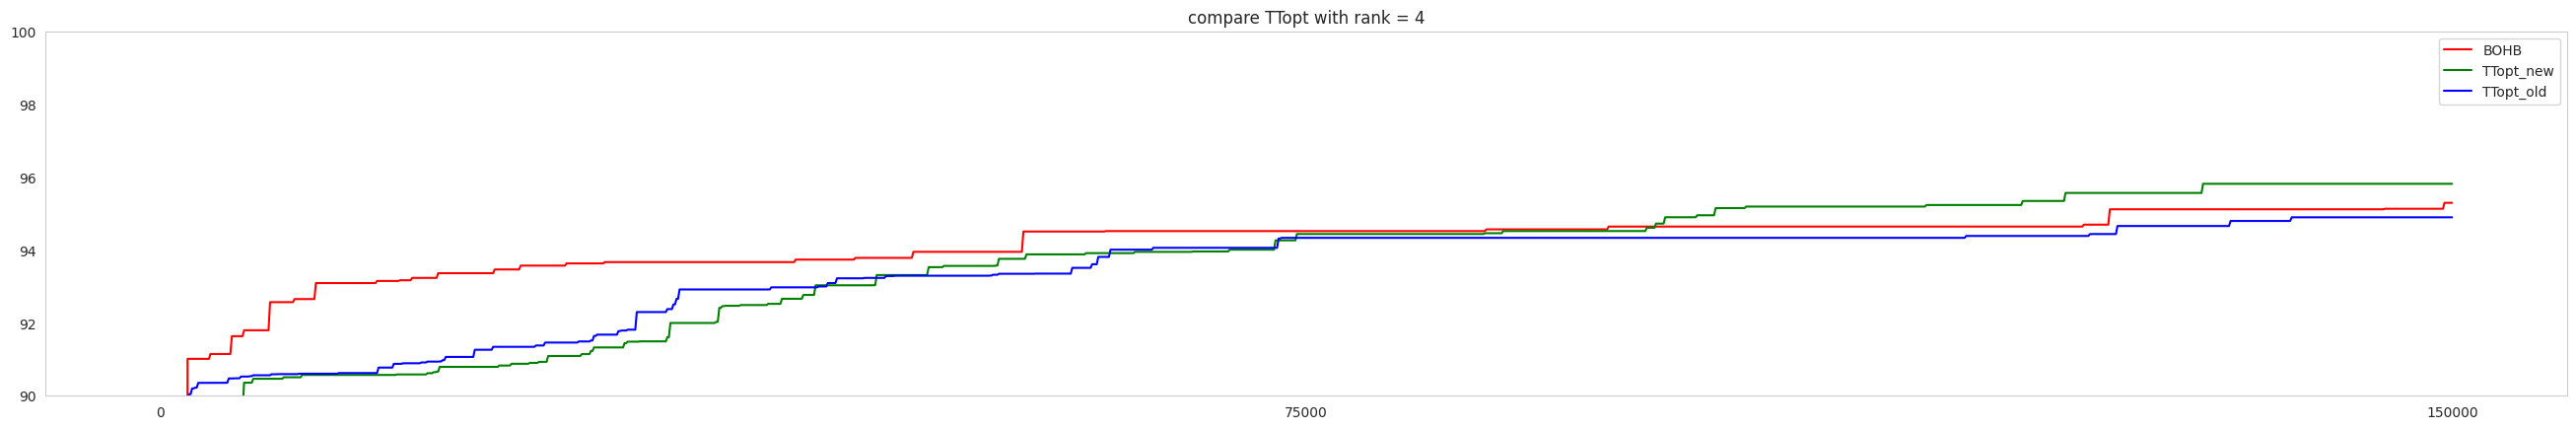

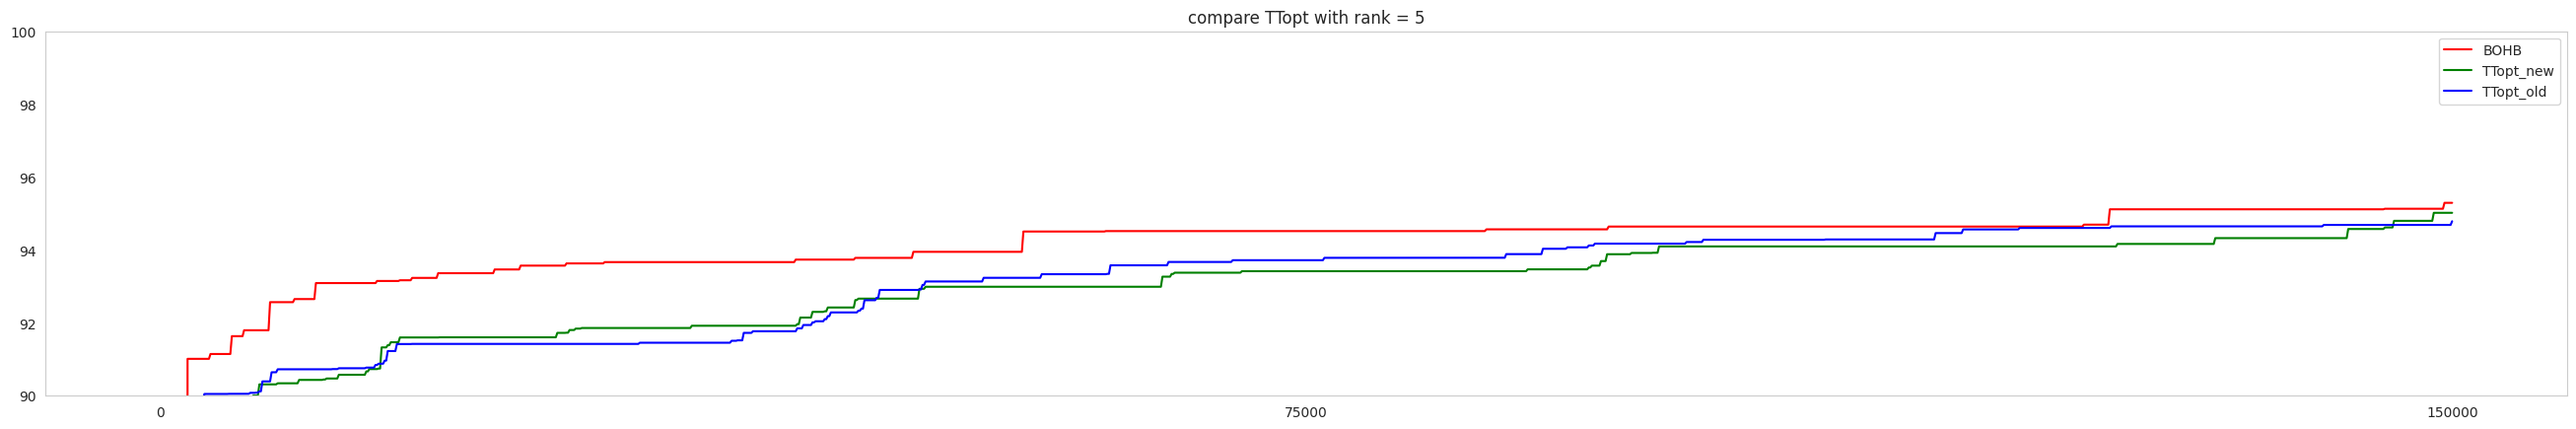

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/BOHB_nasbench211/optimization_curves.csv"
BOHB_curve_df = pd.read_csv(file_path)
list_of_cols = BOHB_curve_df.columns
BOHB_curve_df['optimizer'] = "BOHB"

for rank in range(1, 6):
    file_path = f"/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_old_nasbench211/{rank}_optimization_curves.csv"
    TTopt1_curve_df = pd.read_csv(file_path)
    TTopt1_curve_df['optimizer'] = "TTopt_old"
    file_path = f"/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_new_nasbench211/{rank}_optimization_curves.csv"
    TTopt2_curve_df = pd.read_csv(file_path)
    TTopt2_curve_df['optimizer'] = "TTopt_new"

    build_plot_from_df(pd.concat([BOHB_curve_df,TTopt1_curve_df,TTopt2_curve_df]), title=f"compare TTopt with rank = {rank}", with_std=False)

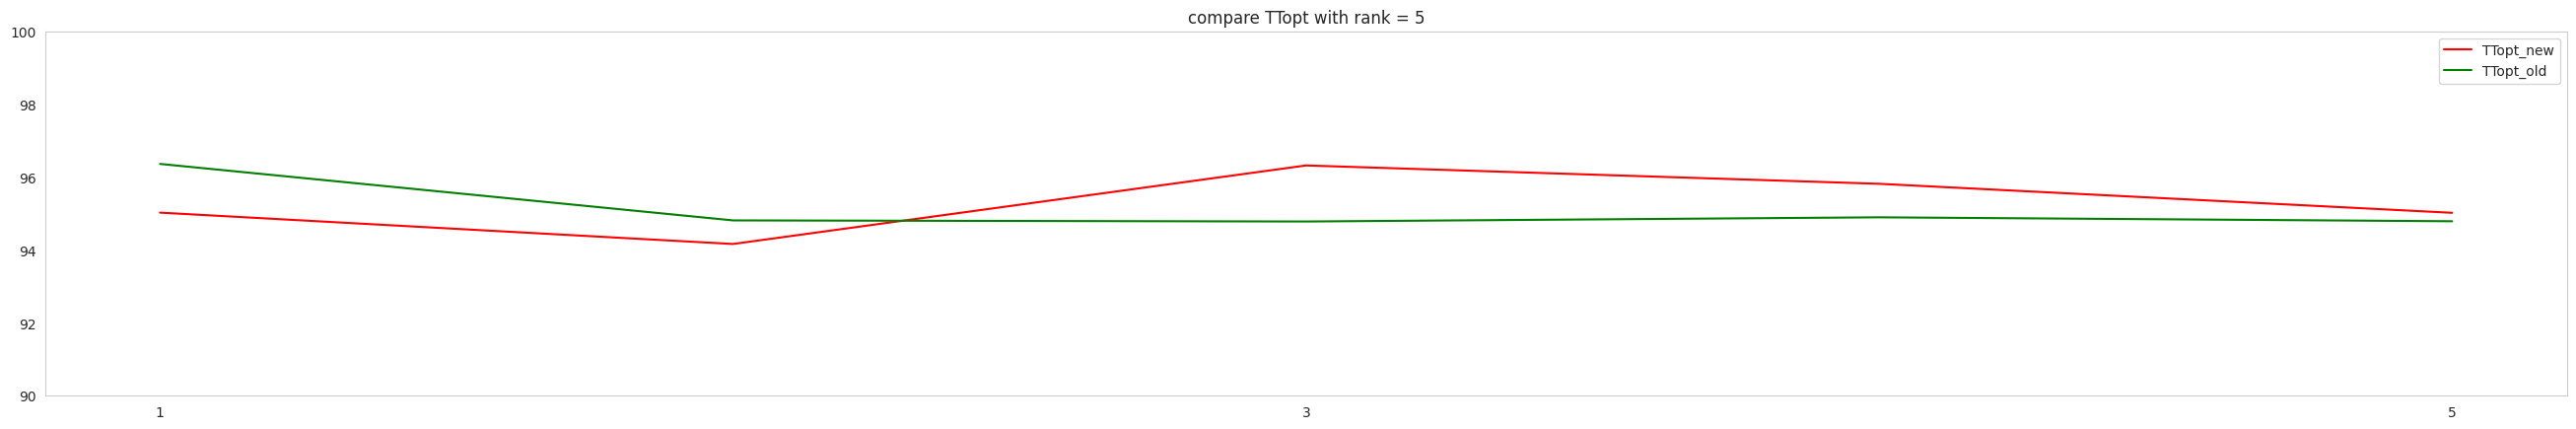

   optimizer          1          2          3          4          5
0  TTopt_old  96.359886  94.810386  94.780425  94.895377  94.786998
1  TTopt_new  95.023544  94.163564  96.318054  95.814608  95.018875


In [ ]:
rank_dict = {'optimizer':["TTopt_old","TTopt_new"]}

for rank in range(1, 6):
    rank_dict[rank] = []
    file_path = f"/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_old_nasbench211/{rank}_optimization_curves.csv"
    TTopt1_curve_df = pd.read_csv(file_path)
    rank_dict[rank].append(TTopt1_curve_df['150000'].mean())
    file_path = f"/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_new_nasbench211/{rank}_optimization_curves.csv"
    TTopt2_curve_df = pd.read_csv(file_path)
    rank_dict[rank].append(TTopt2_curve_df['150000'].mean())

rank_df = pd.DataFrame.from_dict(rank_dict)
build_plot_from_df(rank_df, title=f"compare TTopt with rank = {rank}", with_std=False)
print(rank_df)

The best rank for previous version of TTopt with NASBenchmark211 is 1 and the best rank for current version is 3. But previous version has a little bit better result and was leading during the hole prosses of optimization so I'd choose it.

Let's visualize optimization curves from all the optimizers with best parameters. Transparent plot shows the standard deviation at 10 runs.

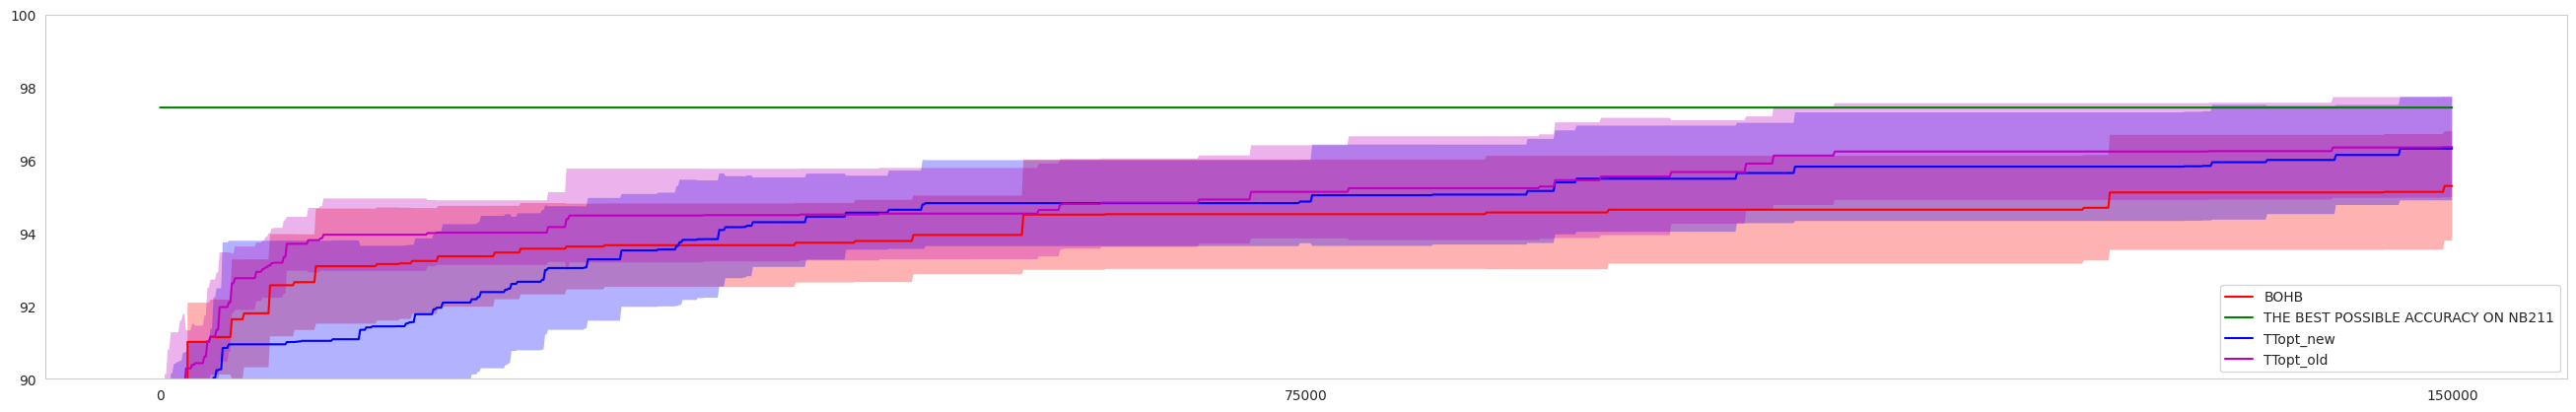

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/BOHB_nasbench211/optimization_curves.csv"
BOHB_curve_df = pd.read_csv(file_path)
list_of_cols = BOHB_curve_df.columns
BOHB_curve_df['optimizer'] = "BOHB"
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_old_nasbench211/1_optimization_curves.csv"
TTopt1_curve_df = pd.read_csv(file_path)
TTopt1_curve_df['optimizer'] = "TTopt_old"
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_new_nasbench211/3_optimization_curves.csv"
TTopt2_curve_df = pd.read_csv(file_path)
TTopt2_curve_df['optimizer'] = "TTopt_new"


BEST_VALUE_DF = pd.DataFrame.from_dict( {k: [BEST_POSSIBLE_ACCURACY_ON_NB211] for k in BOHB_curve_df.keys()} )
BEST_VALUE_DF['optimizer'] = "THE BEST POSSIBLE ACCURACY ON NB211"

build_plot_from_df(pd.concat([BOHB_curve_df,TTopt1_curve_df,TTopt2_curve_df, BEST_VALUE_DF]))

<ipython-input-43-e28e4b5d73f2>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_mean = n_df.mean()
<ipython-input-43-e28e4b5d73f2>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_std = n_df.std()
<ipython-input-43-e28e4b5d73f2>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_mean = n_df

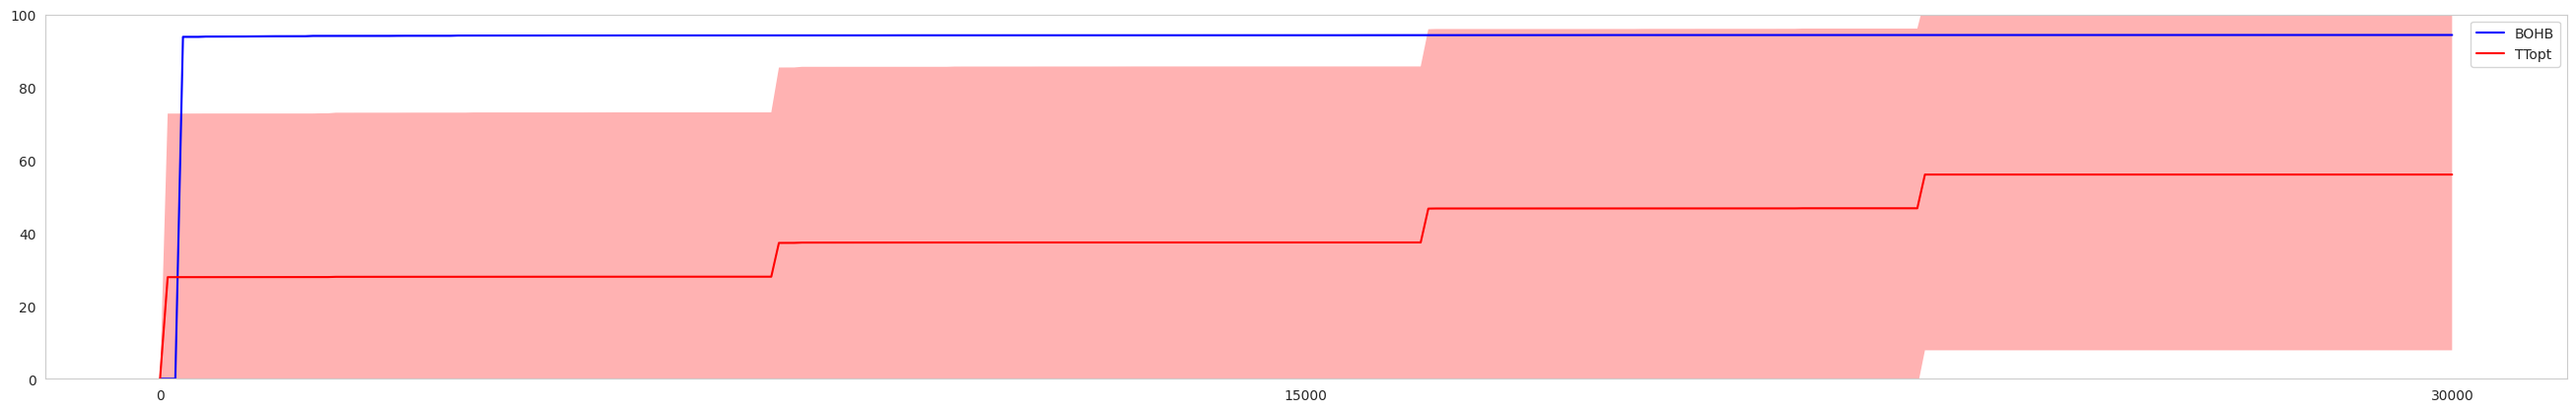

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/BOHB_nasbench311/optimization_curves.csv"
BOHB_curve_df = pd.read_csv(file_path)
list_of_cols = BOHB_curve_df.columns
BOHB_curve_df['optimizer'] = "BOHB"
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_nasbench311/optimization_curves.csv"
TTopt_curve_df = pd.read_csv(file_path)
TTopt_curve_df['optimizer'] = "TTopt"

build_plot_from_df(pd.concat([BOHB_curve_df,TTopt_curve_df]), y_min=0)

In 40% of cases, TTOpt did not find an appropriate architecture at all.

TTOpt cannot understand the points in the search space where the function is defined and where it is not. Therefore, the value being optimized is equal to zero, then the optimizer randomly finds several closely spaced architectures with mean accuracy



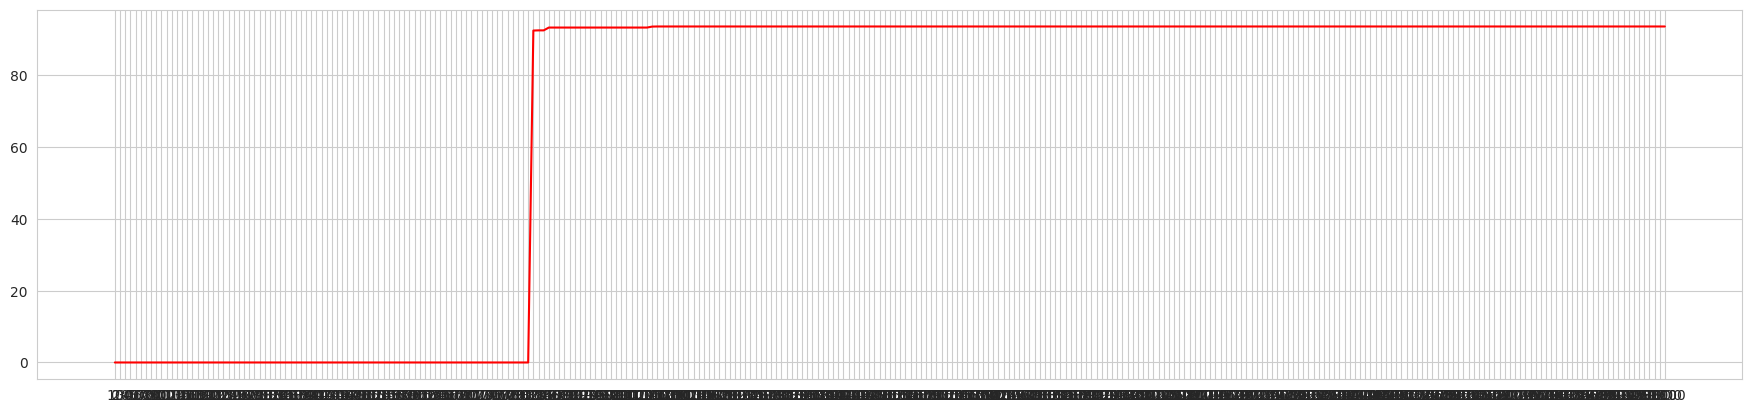

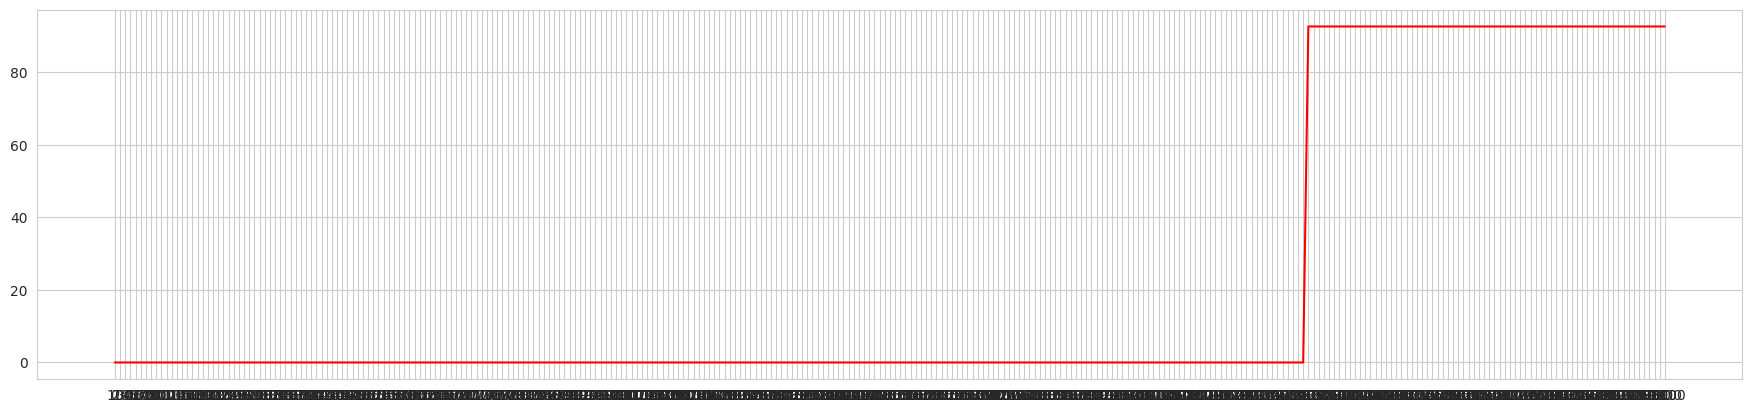

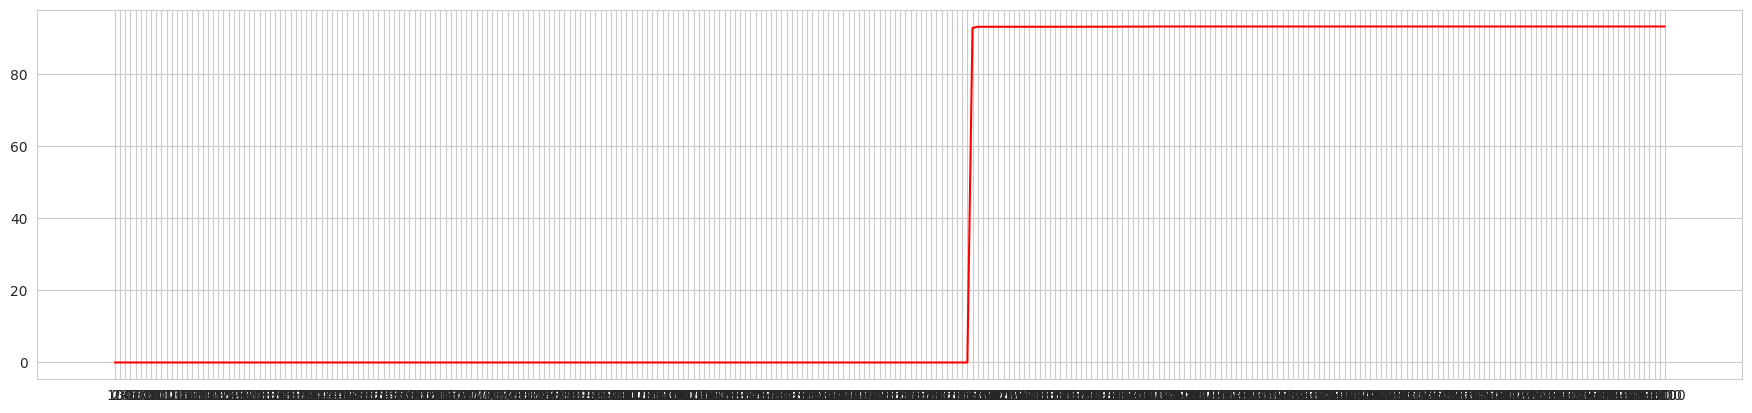

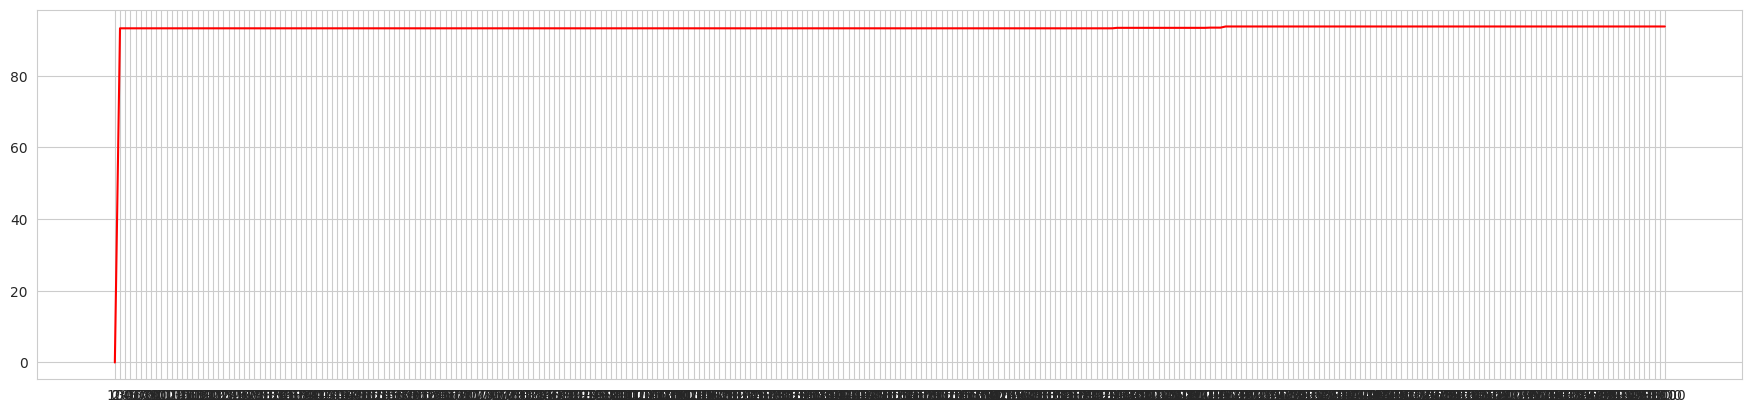

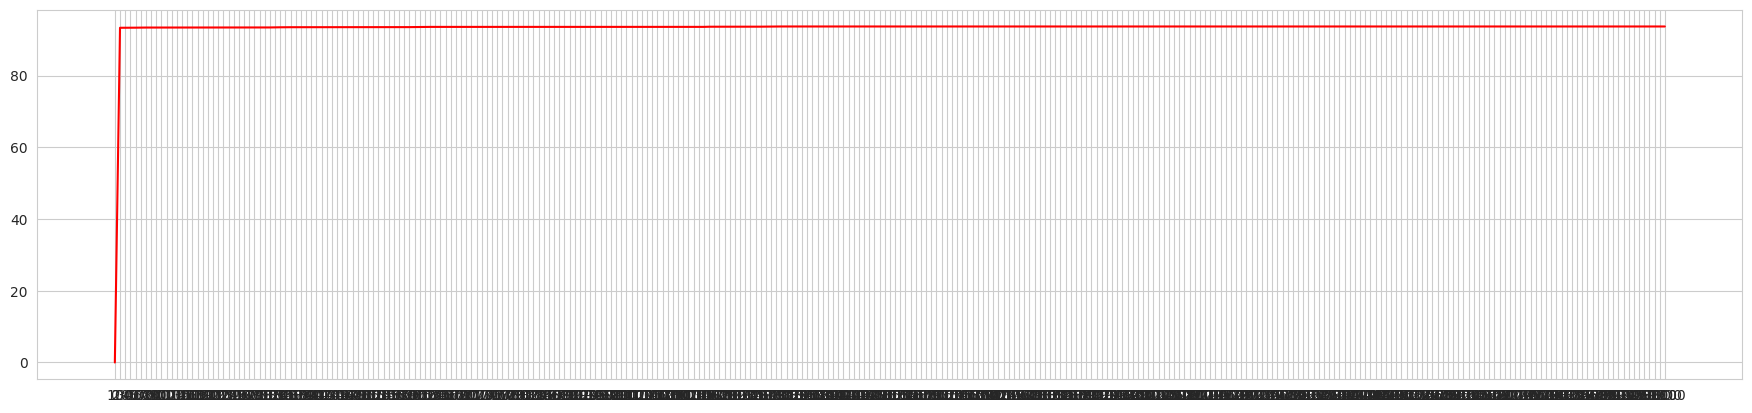

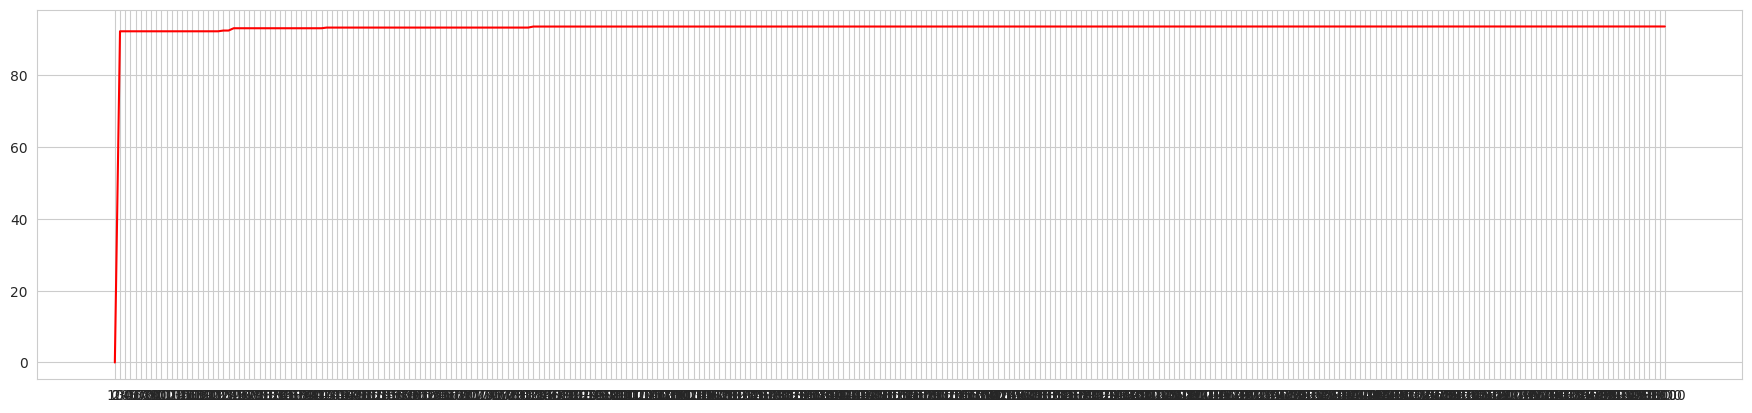

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_nasbench311/optimization_curves.csv"
TTopt_curve_df = pd.read_csv(file_path)
TTopt2_curve_df = TTopt_curve_df[TTopt_curve_df[list_of_cols[-1]]!=0]
x = TTopt2_curve_df.keys()

for _, row in TTopt2_curve_df.iterrows():
  plt.figure().set_figwidth(22)
  plt.plot(x, row, color="r")
  plt.show()

<ipython-input-43-e28e4b5d73f2>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_mean = n_df.mean()
<ipython-input-43-e28e4b5d73f2>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_std = n_df.std()
<ipython-input-43-e28e4b5d73f2>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  n_df_mean = n_df

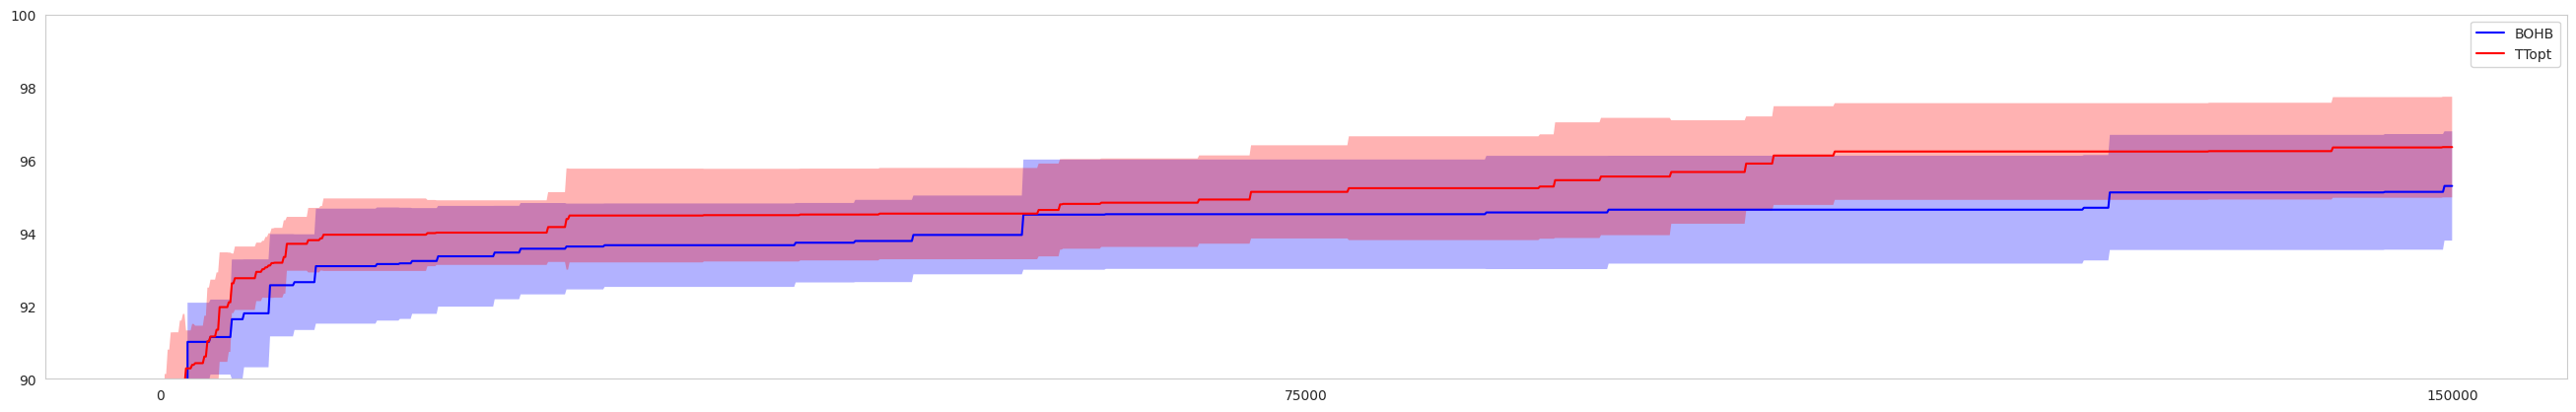

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/BOHB_nasbench211/optimization_curves.csv"
BOHB_curve_df = pd.read_csv(file_path)
list_of_cols = BOHB_curve_df.columns
BOHB_curve_df['optimizer'] = "BOHB"
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_nasbench211/optimization_curves.csv"
TTopt_curve_df = pd.read_csv(file_path)
TTopt_curve_df['optimizer'] = "TTopt"

build_plot_from_df(pd.concat([BOHB_curve_df,TTopt_curve_df]))

In [ ]:
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/BOHB_nasbench211/optimization_curves.csv"
BOHB_curve_df = pd.read_csv(file_path)
list_of_cols = BOHB_curve_df.columns
BOHB_curve_df['optimizer'] = "BOHB"
file_path="/content/gdrive/MyDrive/MachineLearning/NAS/TTopt_nasbench211/optimization_curves.csv"
TTopt_curve_df = pd.read_csv(file_path)
TTopt_curve_df['optimizer'] = "TTopt"

build_plot_from_df(pd.concat([BOHB_curve_df,TTopt_curve_df]))

TTOpt is highly efficient for search space benchmarks that are fully defined.

#Conclusion
In my opinion, optimizers are extremely useful techniques in machine learning. But unfortunately, in real projects it is difficult to allocate even 64 GPU hours (30,000 epochs). I believe this budget can be reduced by applying the Successive Halving principle to TTOpt (reduce the number of epochs by using long-term memory). But for this, it is necessary to overwrite the ttopt function from ttopt_raw.py so that it stops after each sweep and returns not a single minimum value, but the number of points. It would also be a good improvement to set optimization flags for each hyper parameter separately, depending on its specifications.